In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, chi2, mutual_info_classif, f_classif, SelectKBest, SequentialFeatureSelector
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight

from utils import calculate_evaluation_metrics, display_shap_plot, display_lime_plot, plot_class_probability_distributions, get_selected_features

<h3>Classification results, input: statistics from the <b>first 5</b> seasons</h3>

In [2]:
df_5 = pd.read_csv('data/final_dataset_5_seasons.csv', low_memory=False)

class_mapping = {'bench': 0, 'starter': 1, 'all-star': 2}
df_5['Player_class_num'] = df_5['Player_class'].map(class_mapping)

final_dataset_5_seasons = df_5[get_selected_features(5)]

X = final_dataset_5_seasons.drop(columns=['Player_class_num'])
y = final_dataset_5_seasons['Player_class_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Best parameters: {'logreg__C': 10, 'logreg__class_weight': 'balanced'}
Best F1 macro: 0.8788470418470418

=== Classification Report ===
               precision    recall  f1-score   support

           0       0.69      0.77      0.73        88
           1       0.58      0.48      0.53        75
           2       0.62      0.69      0.65        26

    accuracy                           0.65       189
   macro avg       0.63      0.65      0.64       189
weighted avg       0.64      0.65      0.64       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8684390352259769
PR AUC: 0.7811639864994732


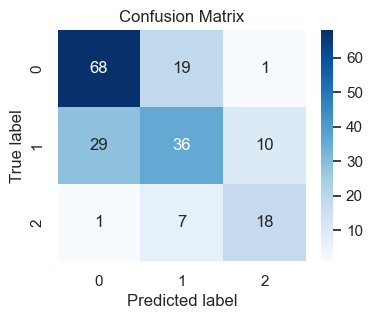

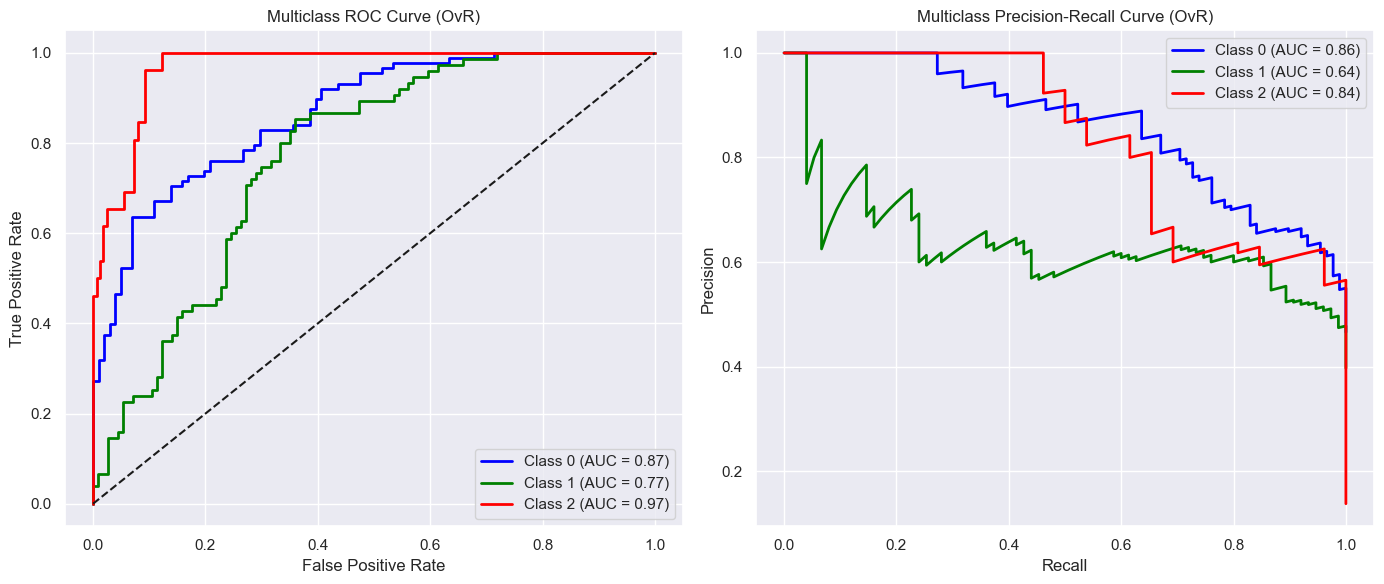

In [22]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc_ovo',
    cv=cv,
    n_jobs=-1
)

y_pred = grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best F1 macro:", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

calculate_evaluation_metrics(best_model, y_test, y_pred, y_pred_proba)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.69      0.77      0.73        88
           1       0.58      0.48      0.53        75
           2       0.62      0.69      0.65        26

    accuracy                           0.65       189
   macro avg       0.63      0.65      0.64       189
weighted avg       0.64      0.65      0.64       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8684390352259769
PR AUC: 0.7811639864994732


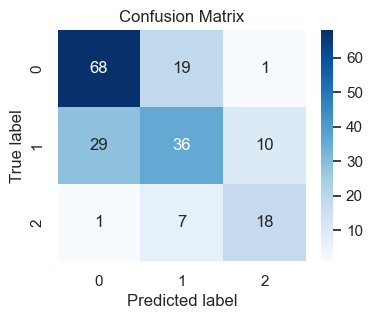

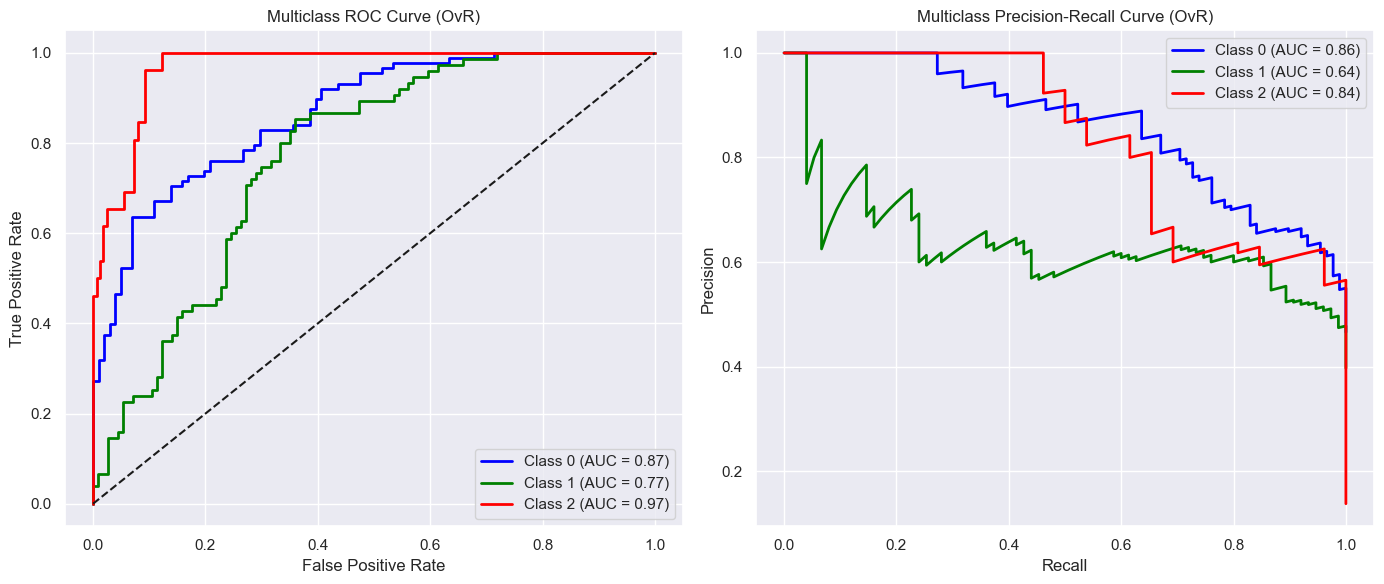


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.97      0.85      0.90       163
           1       0.47      0.85      0.60        26

    accuracy                           0.85       189
   macro avg       0.72      0.85      0.75       189
weighted avg       0.90      0.85      0.86       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.9443133553563001
PR AUC: 0.7625466363742263


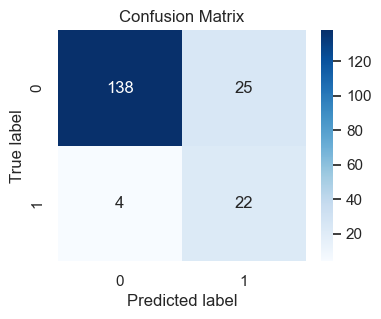

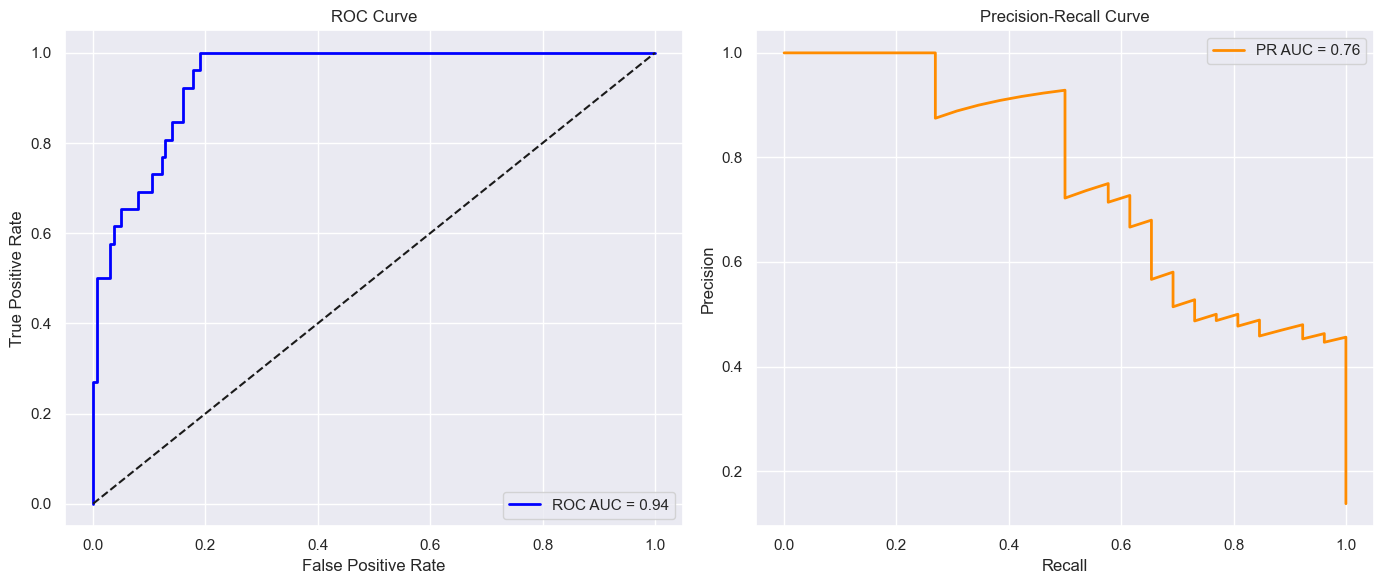


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.78      0.69      0.73       114
           1       0.60      0.71      0.65        75

    accuracy                           0.70       189
   macro avg       0.69      0.70      0.69       189
weighted avg       0.71      0.70      0.70       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7461988304093568
PR AUC: 0.5884288333747354


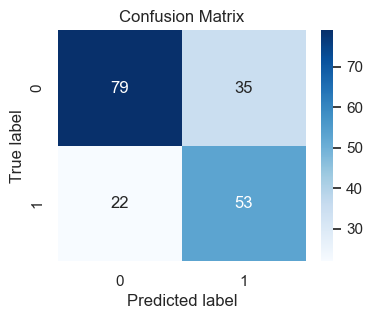

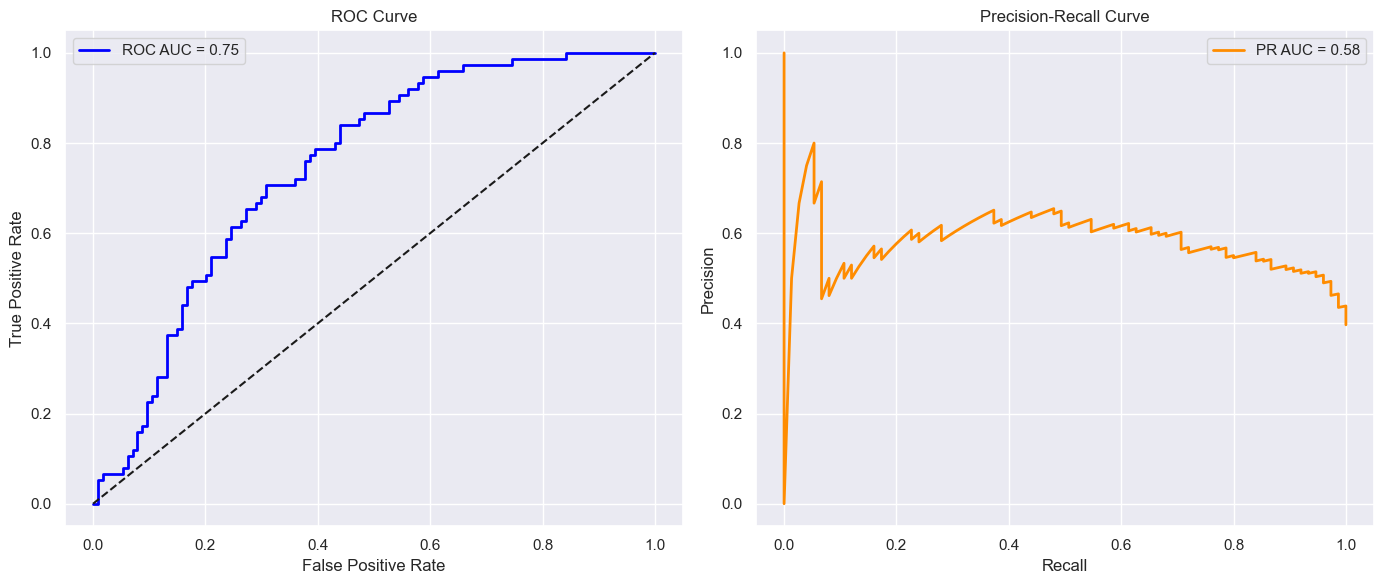


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.86      0.79      0.82       101
           1       0.78      0.85      0.82        88

    accuracy                           0.82       189
   macro avg       0.82      0.82      0.82       189
weighted avg       0.82      0.82      0.82       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8966021602160216
PR AUC: 0.8753682561381297


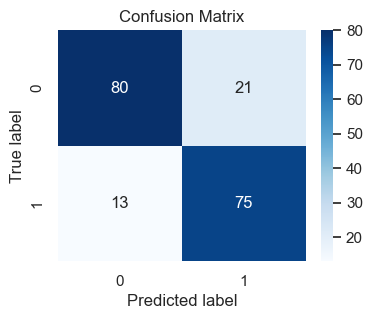

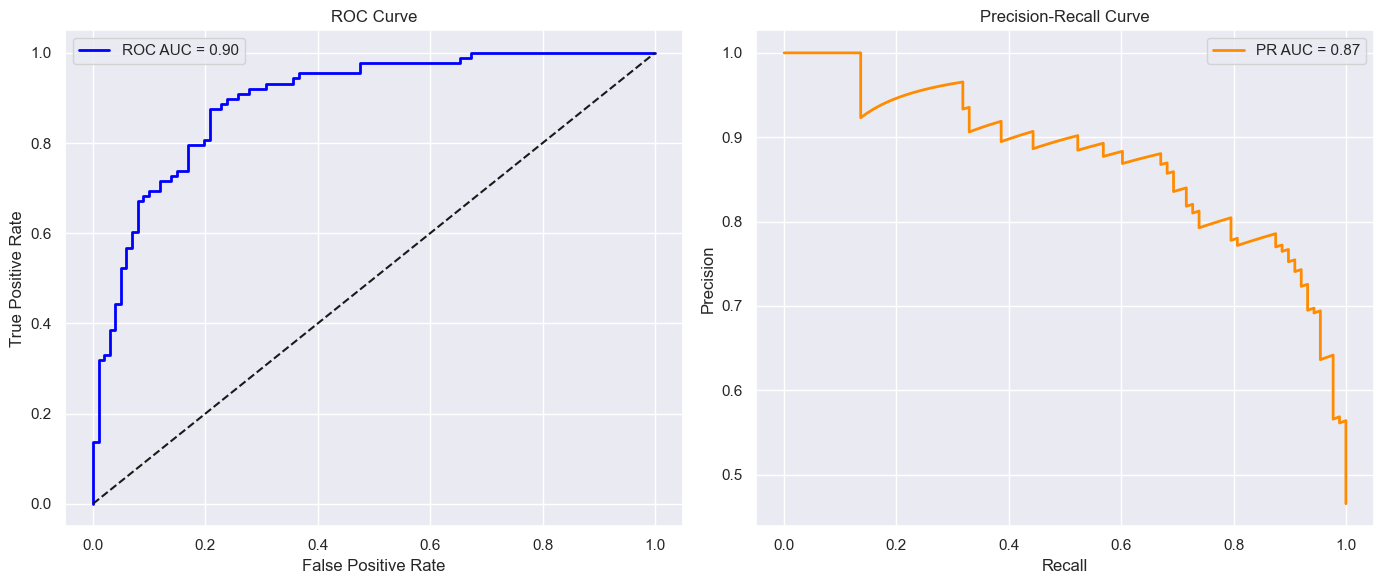

In [12]:
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        C=10,
        class_weight="balanced",
        random_state=42))
])

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

calculate_evaluation_metrics(lr, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_5_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    lr_bin = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            solver='lbfgs',
            C=10,
            class_weight="balanced",
            random_state=42))
    ])

    lr_bin.fit(X_train_bin, y_train_bin)

    y_pred_bin = lr_bin.predict(X_test_bin)
    y_pred_proba_bin = lr_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(lr_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)

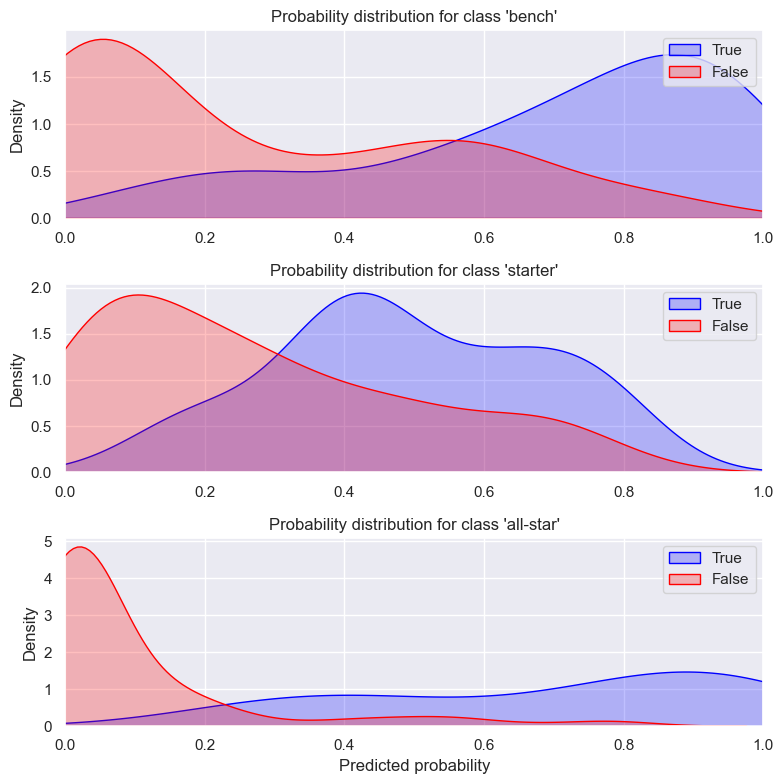

PermutationExplainer explainer: 190it [00:28,  5.97it/s]                         


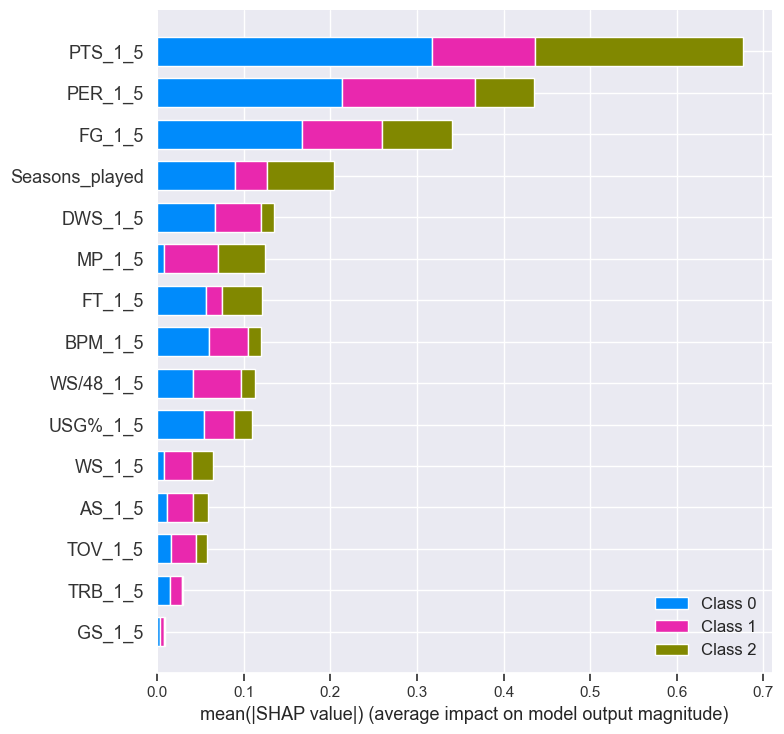

In [24]:
plot_class_probability_distributions(y_test, y_pred_proba)
display_shap_plot(lr, X_train, X_test)

In [13]:
display_lime_plot(lr, X_train, X_test, 0)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.82      0.70      0.76        88
           1       0.60      0.67      0.63        75
           2       0.60      0.69      0.64        26

    accuracy                           0.69       189
   macro avg       0.67      0.69      0.68       189
weighted avg       0.70      0.69      0.69       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8674942248494903
PR AUC: 0.7771730699223953


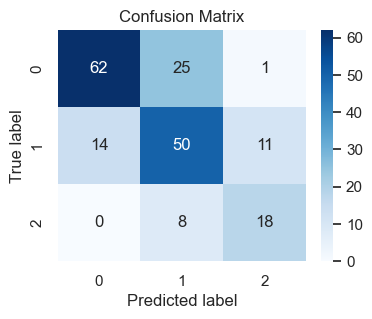

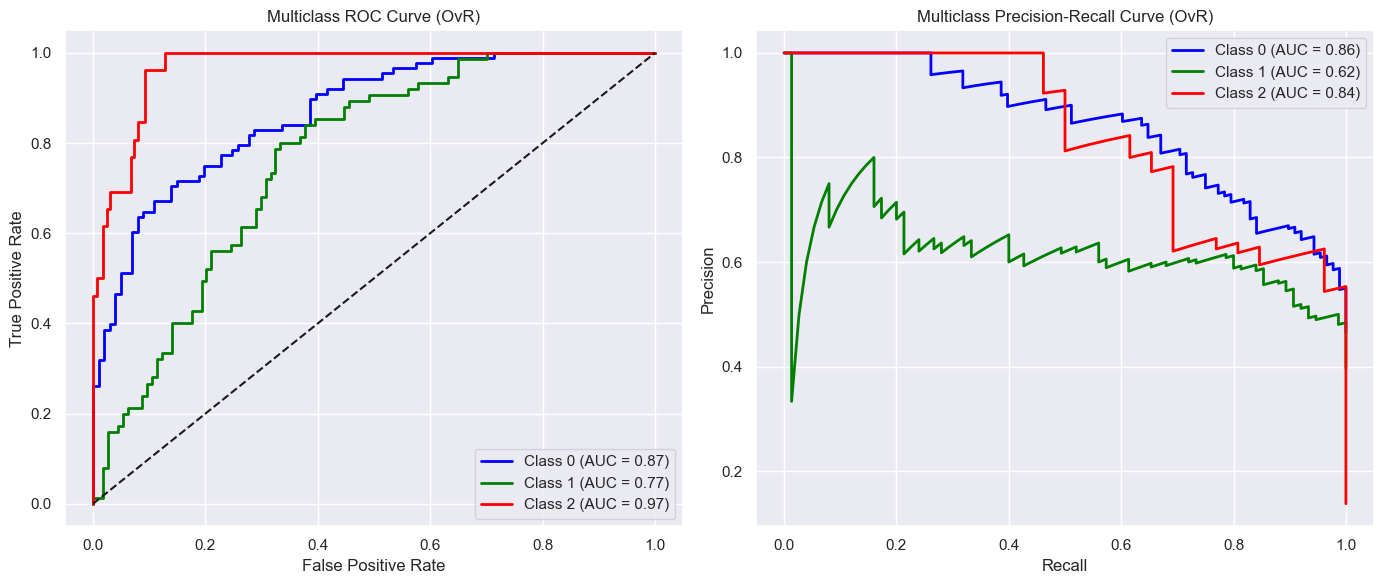


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.94      0.91      0.93       163
           1       0.53      0.65      0.59        26

    accuracy                           0.87       189
   macro avg       0.74      0.78      0.76       189
weighted avg       0.89      0.87      0.88       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.9436054742803209
PR AUC: 0.7584695497452413


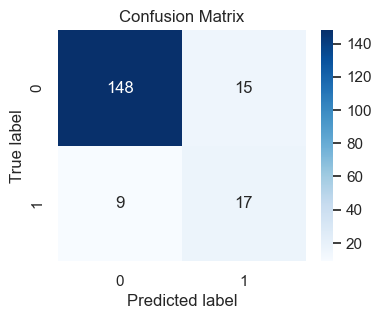

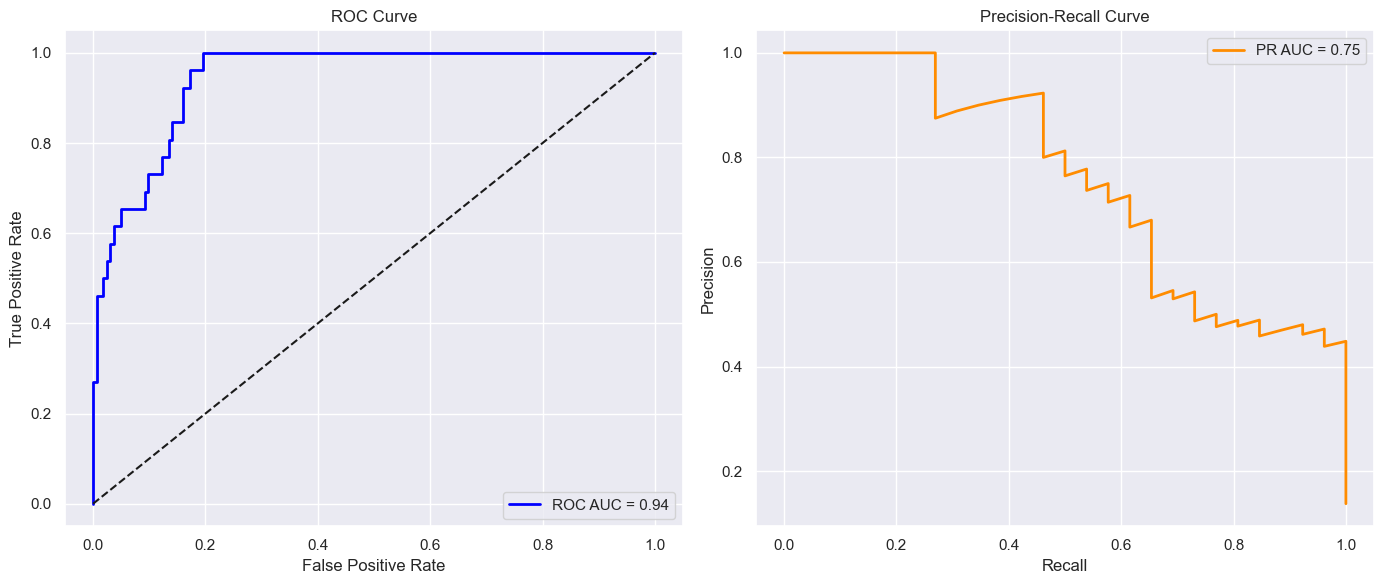


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.87      0.46      0.60       114
           1       0.52      0.89      0.66        75

    accuracy                           0.63       189
   macro avg       0.69      0.67      0.63       189
weighted avg       0.73      0.63      0.62       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7444444444444444
PR AUC: 0.5886546986777005


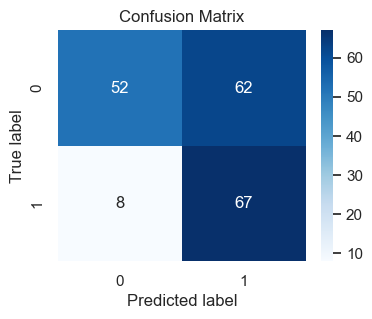

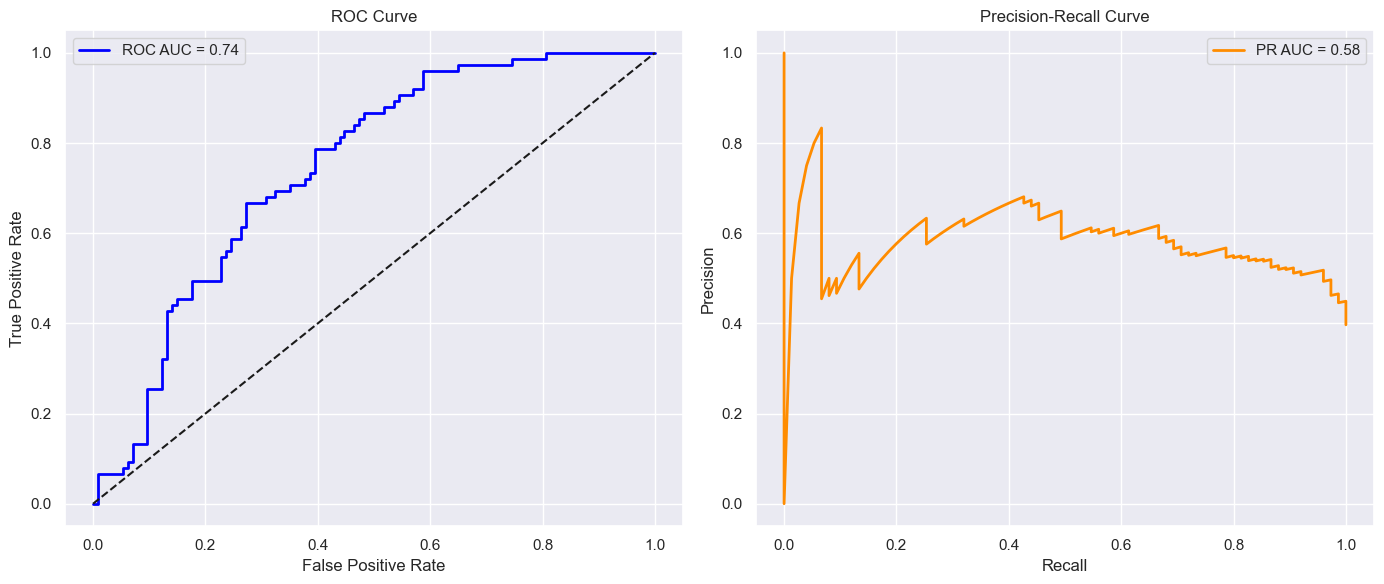


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.92      0.64      0.76       101
           1       0.69      0.93      0.80        88

    accuracy                           0.78       189
   macro avg       0.81      0.79      0.78       189
weighted avg       0.81      0.78      0.77       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8995274527452745
PR AUC: 0.8812141798696722


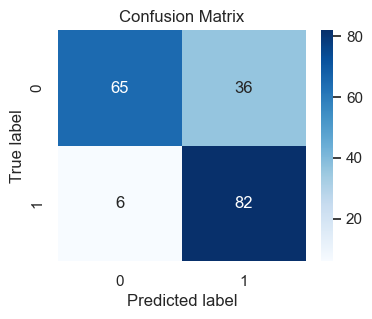

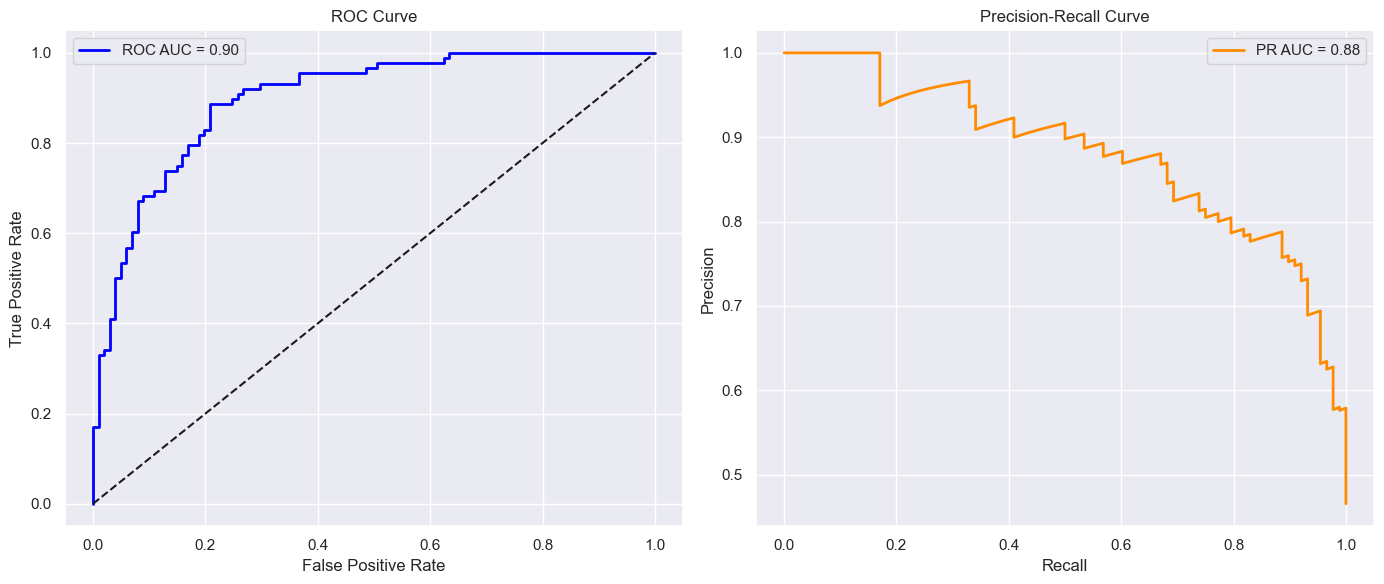

In [11]:
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        C=10,
        class_weight={0:1,1:2,2:6},
        random_state=42))
])

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

calculate_evaluation_metrics(lr, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_5_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    lr_bin = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            solver='lbfgs',
            C=10,
            class_weight={0:1,1:3},
            random_state=42))
    ])

    lr_bin.fit(X_train_bin, y_train_bin)

    y_pred_bin = lr_bin.predict(X_test_bin)
    y_pred_proba_bin = lr_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(lr_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
Player_class_num
1    351
0    351
2    351
Name: count, dtype: int64

=== Classification Report ===
               precision    recall  f1-score   support

           0       0.69      0.77      0.73        88
           1       0.60      0.51      0.55        75
           2       0.68      0.73      0.70        26

    accuracy                           0.66       189
   macro avg       0.66      0.67      0.66       189
weighted avg       0.66      0.66      0.66       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8686538004826704
PR AUC: 0.7813817111906829


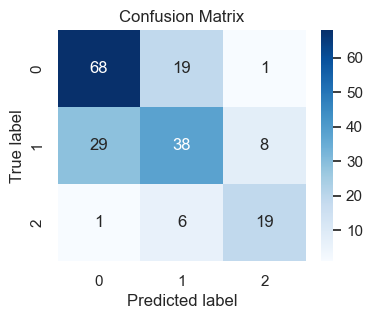

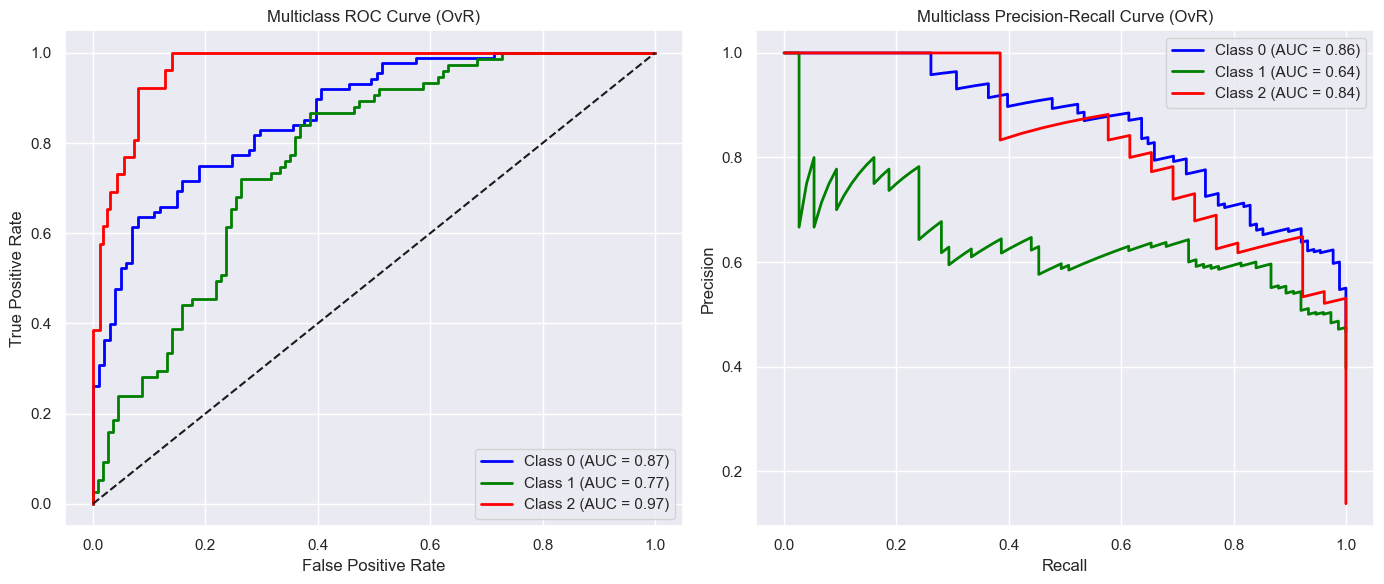

Number of elements in each class:
all-star_class
0    651
1    102
Name: count, dtype: int64

Number of elements in each class after sampling:
all-star_class
0    651
1    651
Name: count, dtype: int64

Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.97      0.85      0.90       163
           1       0.47      0.85      0.60        26

    accuracy                           0.85       189
   macro avg       0.72      0.85      0.75       189
weighted avg       0.90      0.85      0.86       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.9395941481831053
PR AUC: 0.7281032894478788


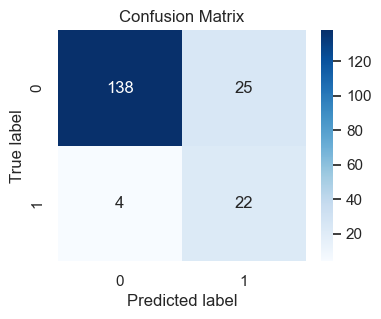

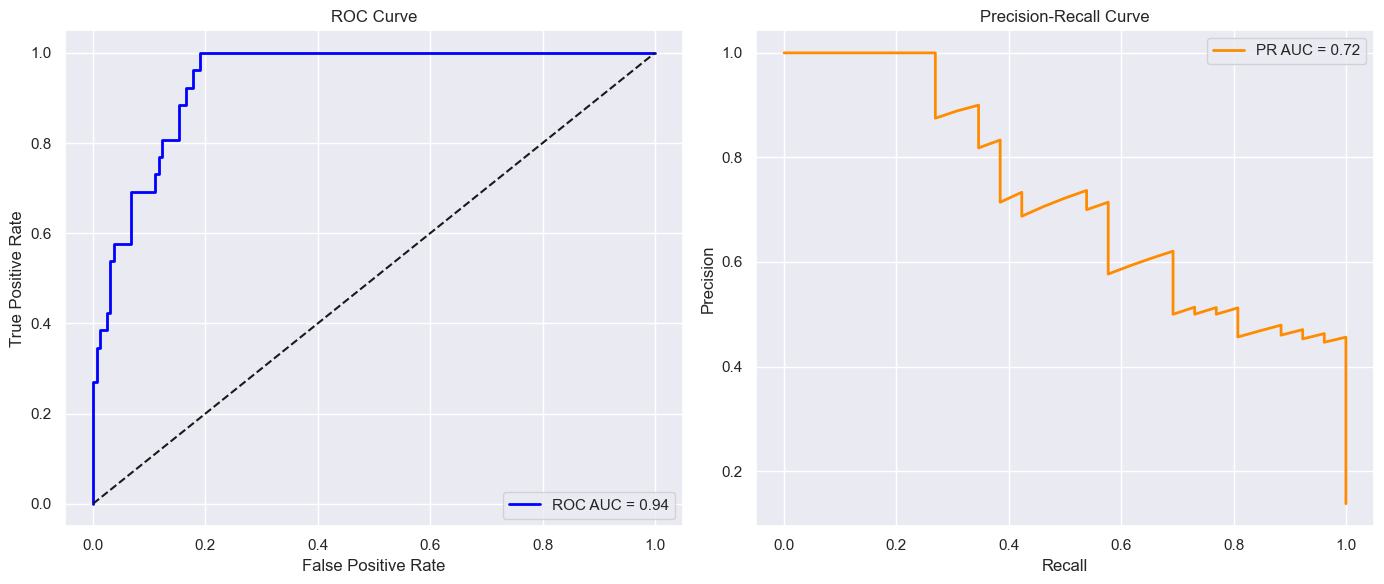

Number of elements in each class:
starter_class
0    453
1    300
Name: count, dtype: int64

Number of elements in each class after sampling:
starter_class
1    453
0    453
Name: count, dtype: int64

Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.76      0.70      0.73       114
           1       0.60      0.67      0.63        75

    accuracy                           0.69       189
   macro avg       0.68      0.68      0.68       189
weighted avg       0.70      0.69      0.69       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7436257309941521
PR AUC: 0.5903951317675604


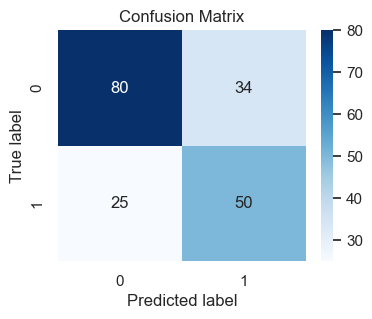

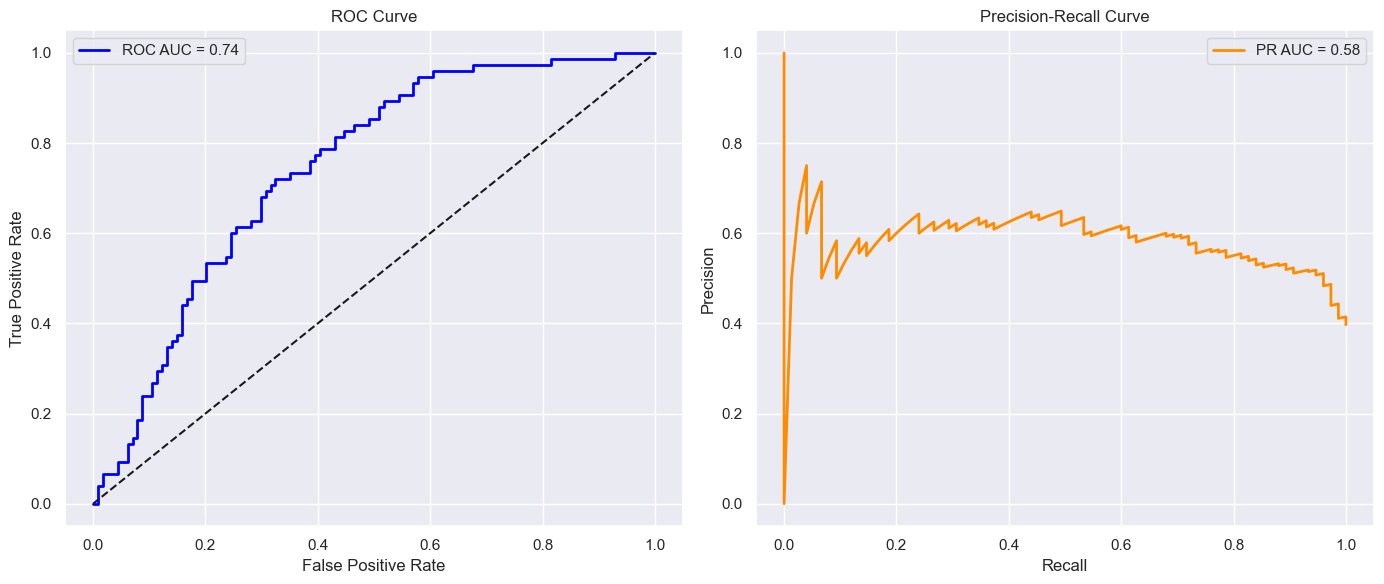

Number of elements in each class:
bench_class
0    402
1    351
Name: count, dtype: int64

Number of elements in each class after sampling:
bench_class
1    402
0    402
Name: count, dtype: int64

Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.86      0.79      0.82       101
           1       0.78      0.85      0.82        88

    accuracy                           0.82       189
   macro avg       0.82      0.82      0.82       189
weighted avg       0.82      0.82      0.82       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8963771377137714
PR AUC: 0.8754041641524211


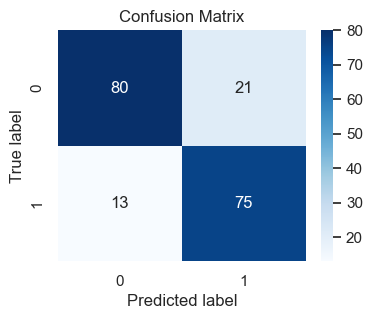

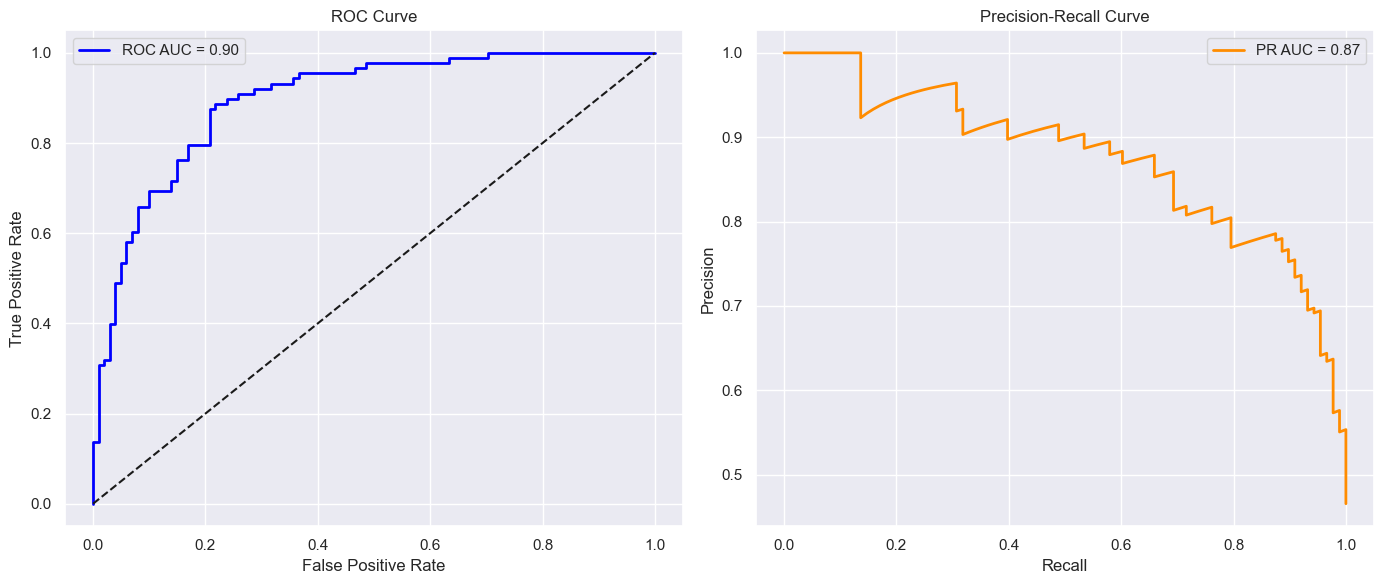

In [37]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print('Number of elements in each class:')
print(y_train.value_counts())
print('\nNumber of elements in each class after sampling:')
print(pd.Series(y_res).value_counts())

lr_smote = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        C=10,
        random_state=42))
])

lr_smote.fit(X_res, y_res)

y_pred = lr_smote.predict(X_test)
y_pred_proba = lr_smote.predict_proba(X_test)

calculate_evaluation_metrics(lr_smote, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_5_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    smote = SMOTE(random_state=42)
    X_res_bin, y_res_bin = smote.fit_resample(X_train_bin, y_train_bin)

    print('Number of elements in each class:')
    print(y_train_bin.value_counts())
    print('\nNumber of elements in each class after sampling:')
    print(pd.Series(y_res_bin).value_counts())
    
    lr_smote_bin = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            solver='lbfgs',
            C=10,
            random_state=42))
    ])

    lr_smote_bin.fit(X_res_bin, y_res_bin)

    y_pred_bin = lr_smote_bin.predict(X_test_bin)
    y_pred_proba_bin = lr_smote_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(lr_smote_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)

<h3>Classification results, input: statistics from the <b>first 3</b> seasons</h3>

In [53]:
df_3 = pd.read_csv('data/final_dataset_3_seasons.csv', low_memory=False)

class_mapping = {'bench': 0, 'starter': 1, 'all-star': 2}
df_3['Player_class_num'] = df_3['Player_class'].map(class_mapping)

final_dataset_3_seasons = df_3[get_selected_features(3)]

X = final_dataset_3_seasons.drop(columns=['Player_class_num'])
y = final_dataset_3_seasons['Player_class_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.71      0.76      0.74        88
           1       0.57      0.52      0.54        75
           2       0.62      0.62      0.62        26

    accuracy                           0.65       189
   macro avg       0.63      0.63      0.63       189
weighted avg       0.64      0.65      0.64       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8255263043380415
PR AUC: 0.7161921360395759


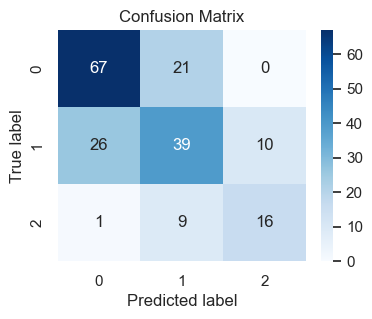

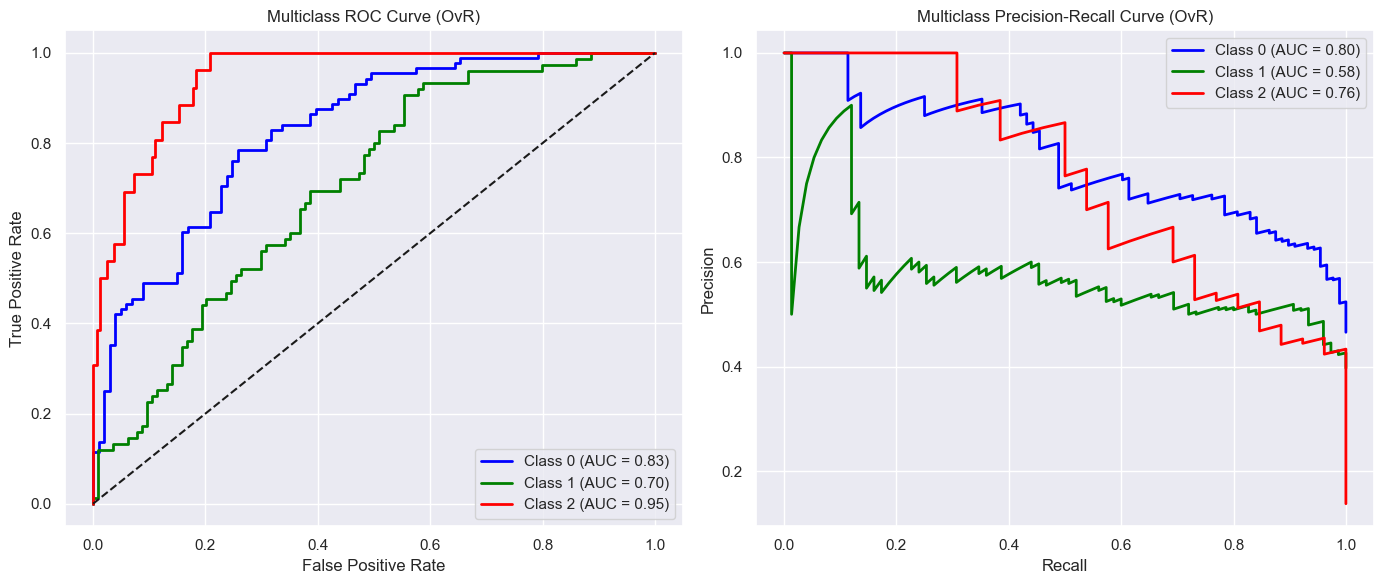


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.95      0.85      0.90       163
           1       0.44      0.73      0.55        26

    accuracy                           0.84       189
   macro avg       0.70      0.79      0.73       189
weighted avg       0.88      0.84      0.85       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.9155261915998112
PR AUC: 0.6761027167249152


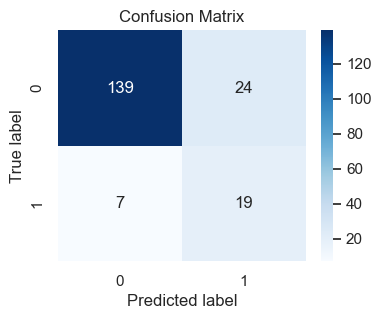

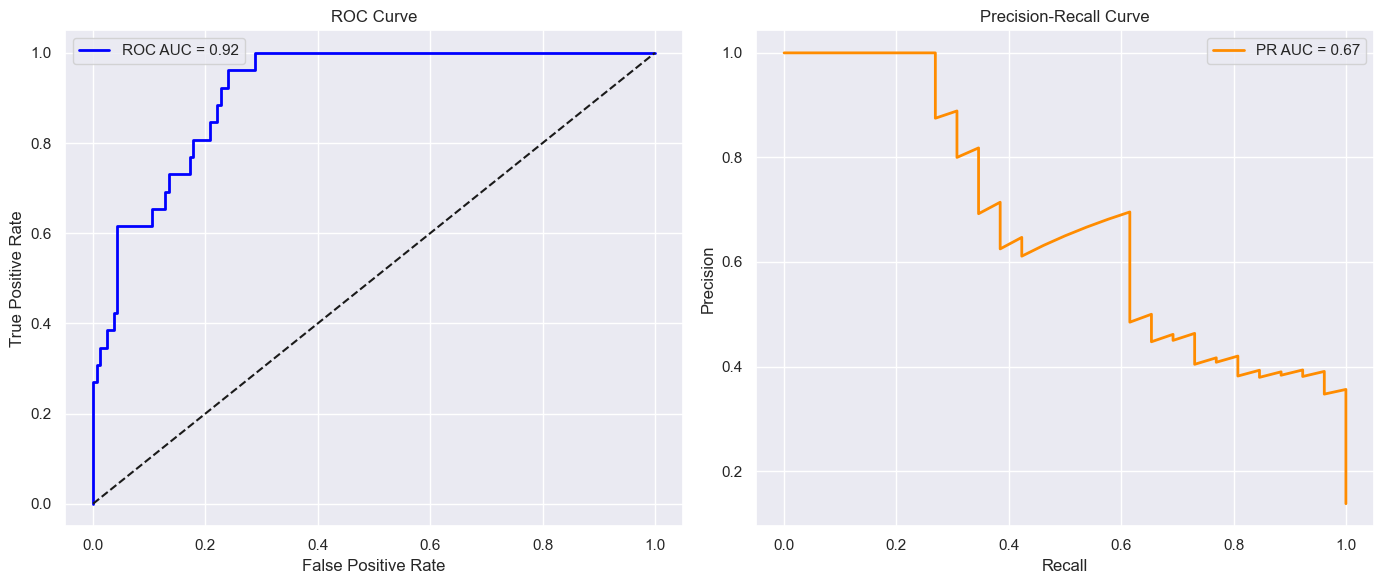


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.81      0.65      0.72       114
           1       0.59      0.77      0.67        75

    accuracy                           0.70       189
   macro avg       0.70      0.71      0.70       189
weighted avg       0.73      0.70      0.70       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.712514619883041
PR AUC: 0.5489981530641173


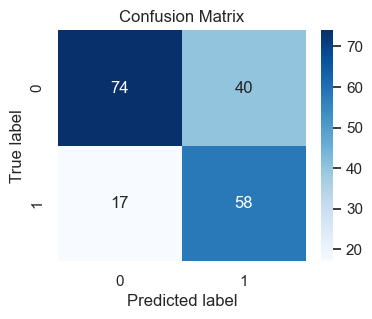

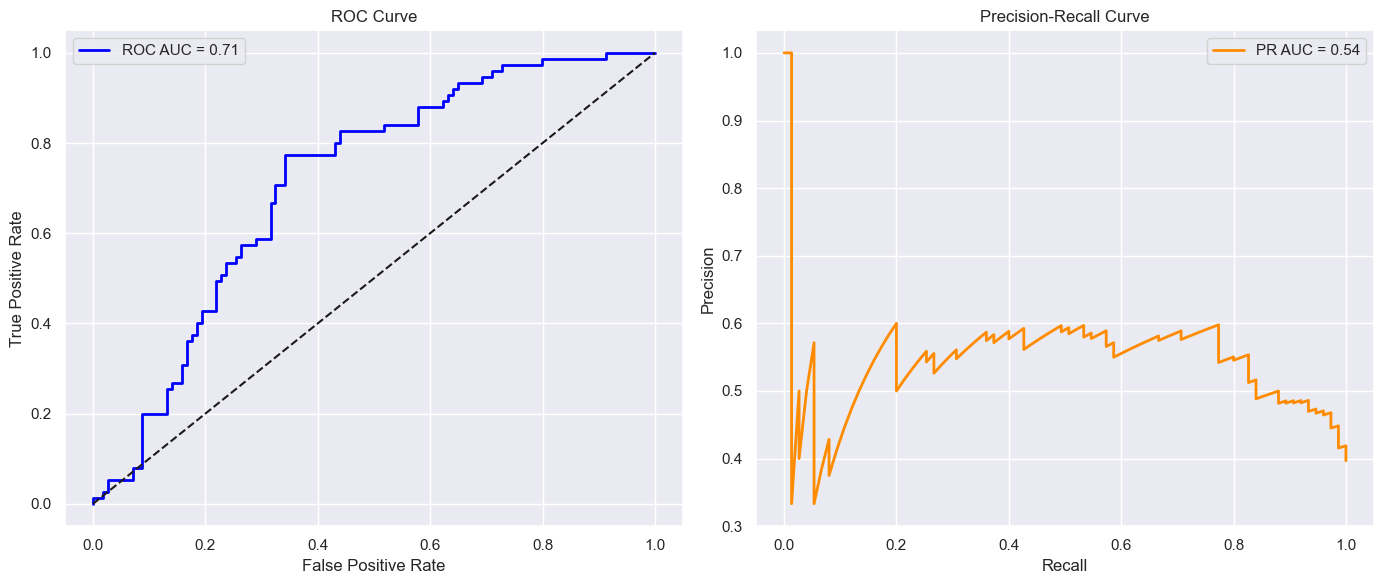


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.81      0.76      0.79       101
           1       0.74      0.80      0.77        88

    accuracy                           0.78       189
   macro avg       0.78      0.78      0.78       189
weighted avg       0.78      0.78      0.78       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8735373537353736
PR AUC: 0.8520516048773357


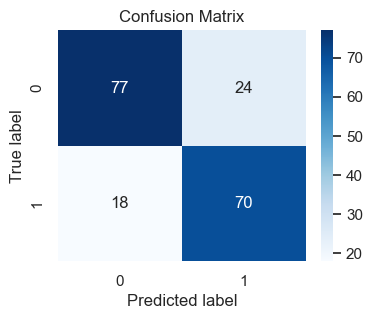

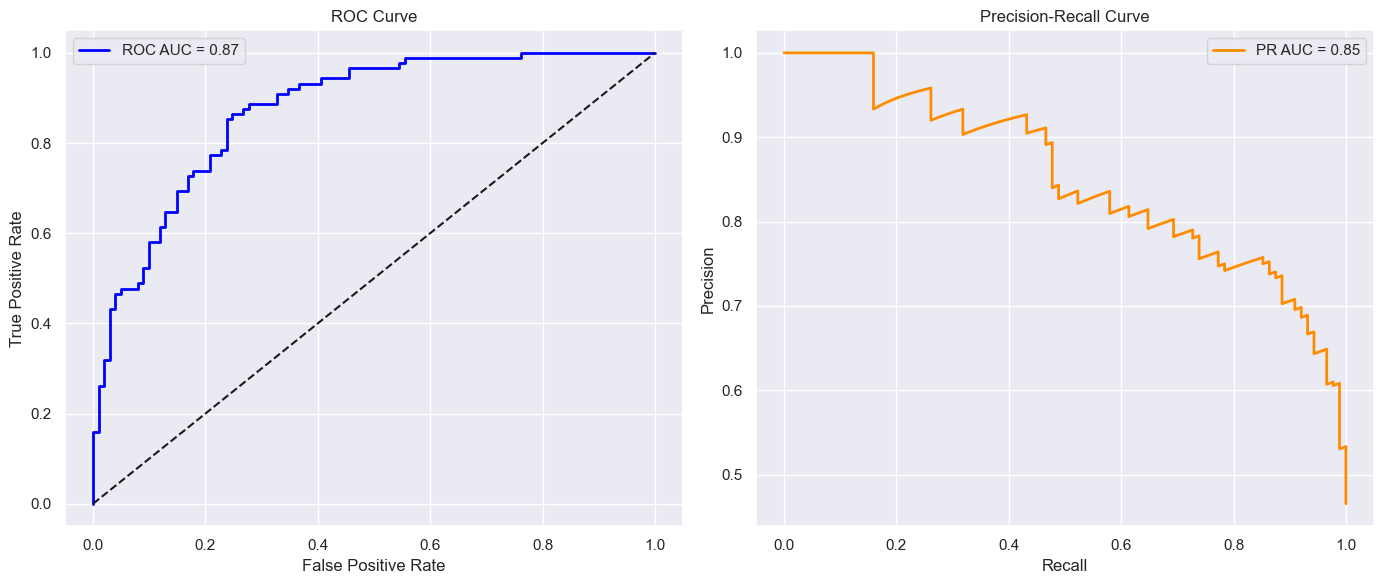

In [54]:
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        C=10,
        class_weight="balanced",
        random_state=42))
])

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

calculate_evaluation_metrics(lr, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_3_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    lr_bin = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            solver='lbfgs',
            C=10,
            class_weight="balanced",
            random_state=42))
    ])

    lr_bin.fit(X_train_bin, y_train_bin)

    y_pred_bin = lr_bin.predict(X_test_bin)
    y_pred_proba_bin = lr_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(lr_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)

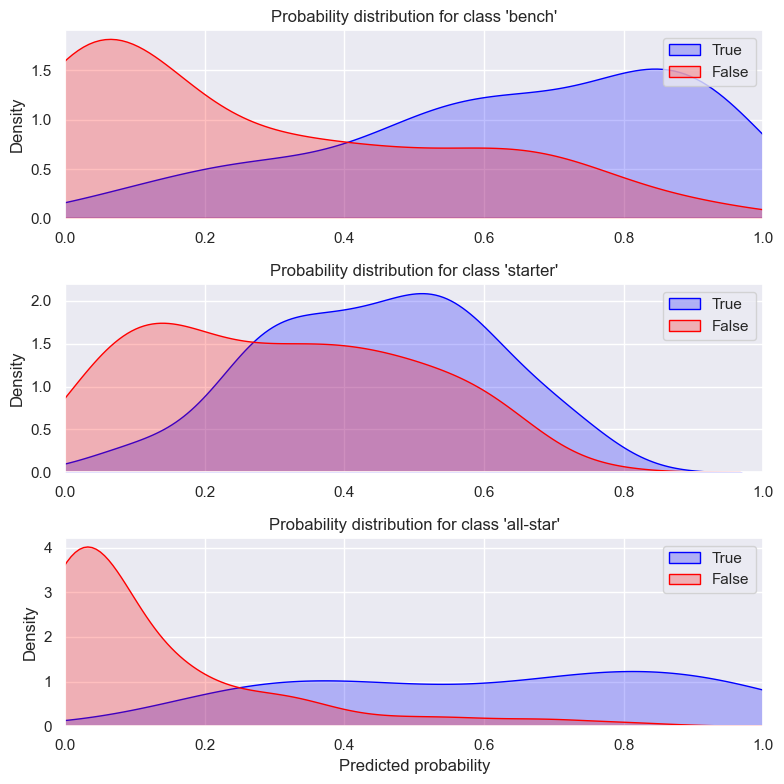

PermutationExplainer explainer: 190it [00:20,  4.67it/s]                         


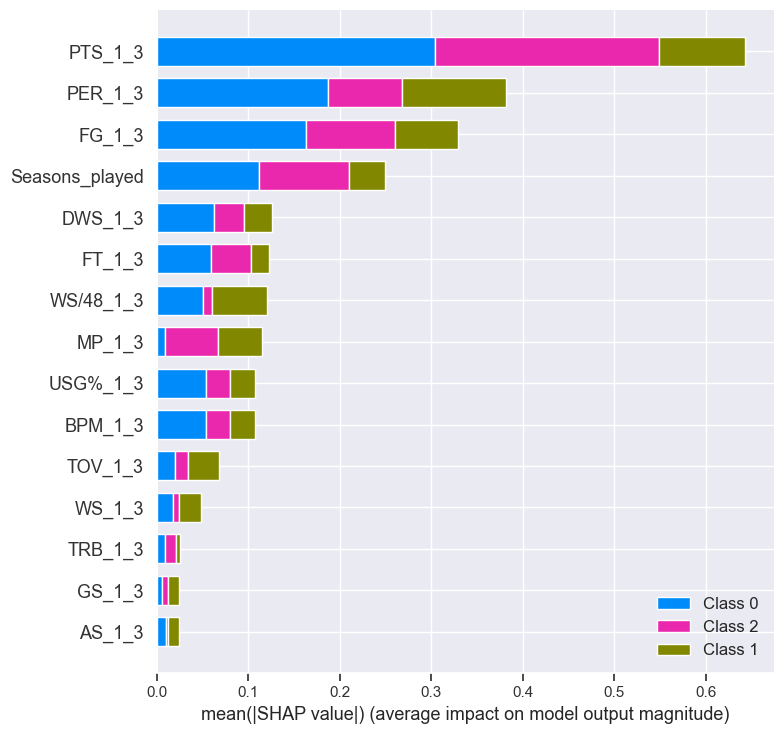

In [55]:
plot_class_probability_distributions(y_test, y_pred_proba)
display_shap_plot(lr, X_train, X_test)

In [56]:
display_lime_plot(lr, X_train, X_test, 0)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.76      0.47      0.58        88
           1       0.50      0.76      0.60        75
           2       0.71      0.58      0.64        26

    accuracy                           0.60       189
   macro avg       0.66      0.60      0.61       189
weighted avg       0.65      0.60      0.60       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8218945218085555
PR AUC: 0.713814268021529


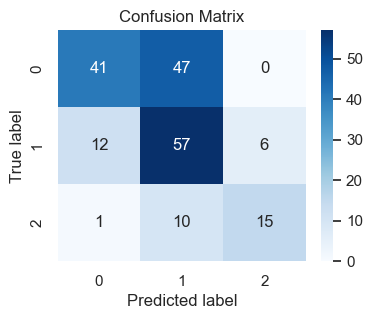

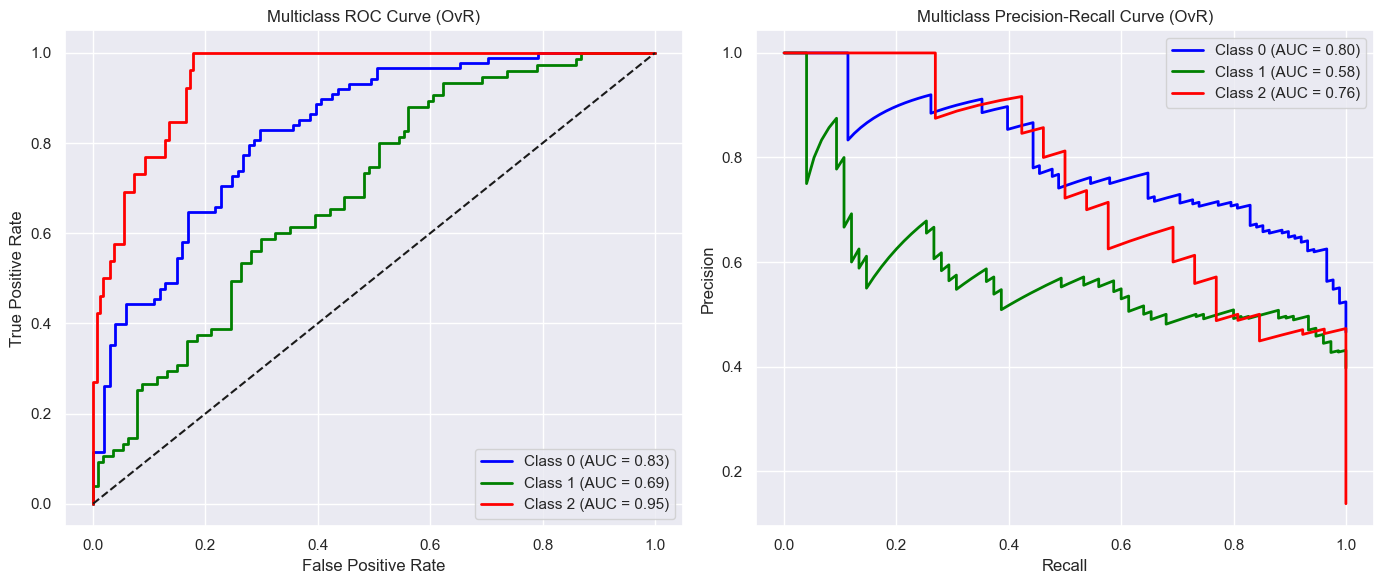


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.94      0.88      0.91       163
           1       0.47      0.65      0.55        26

    accuracy                           0.85       189
   macro avg       0.71      0.77      0.73       189
weighted avg       0.88      0.85      0.86       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.9145823501651722
PR AUC: 0.6636675781996627


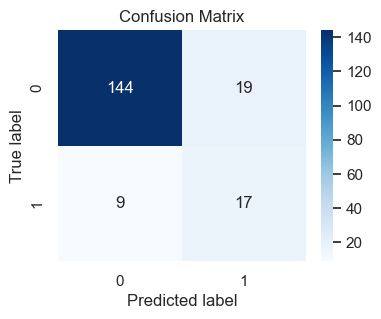

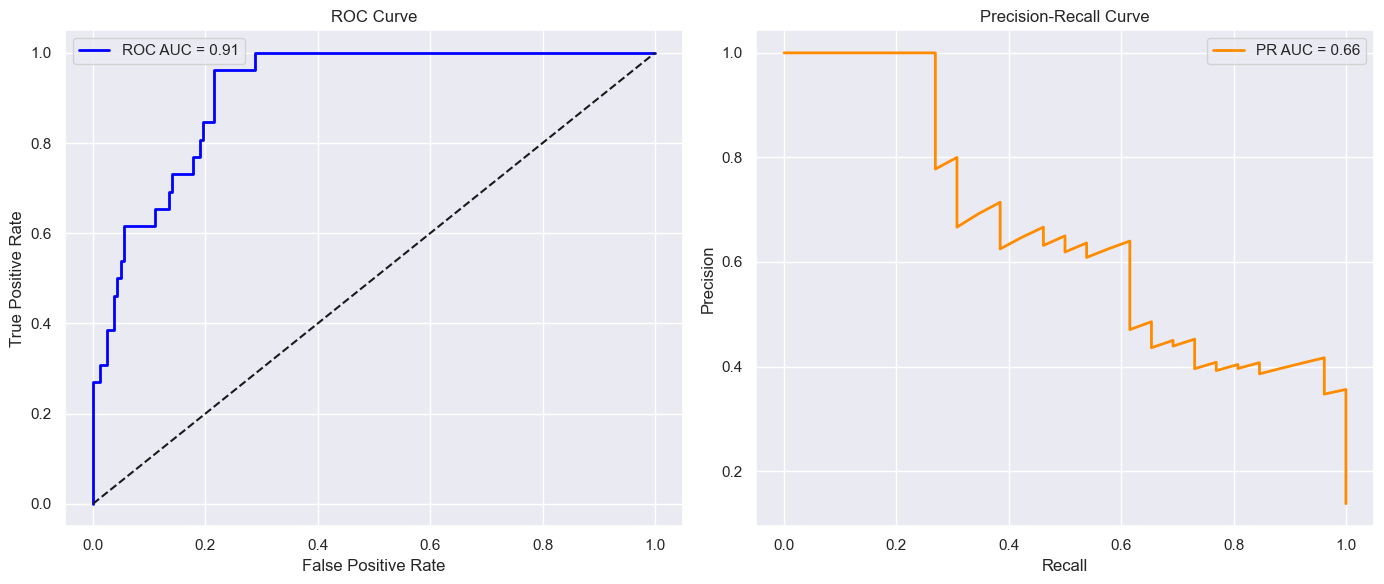


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.89      0.34      0.49       114
           1       0.48      0.93      0.64        75

    accuracy                           0.58       189
   macro avg       0.68      0.64      0.57       189
weighted avg       0.73      0.58      0.55       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7073684210526316
PR AUC: 0.534331802051941


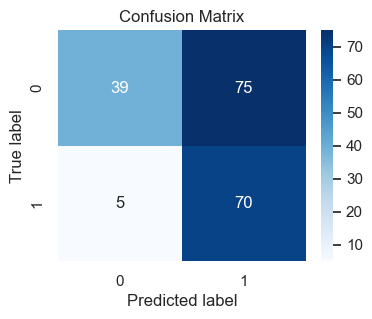

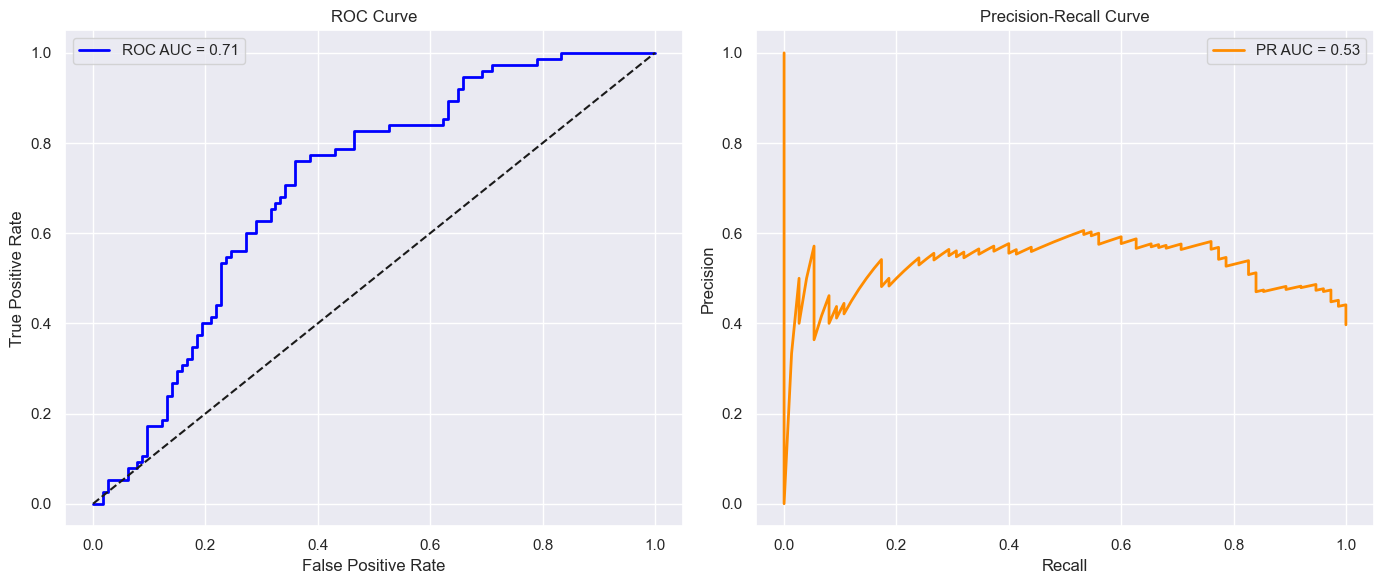


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.93      0.61      0.74       101
           1       0.68      0.94      0.79        88

    accuracy                           0.77       189
   macro avg       0.80      0.78      0.76       189
weighted avg       0.81      0.77      0.76       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8755625562556256
PR AUC: 0.8552318042530951


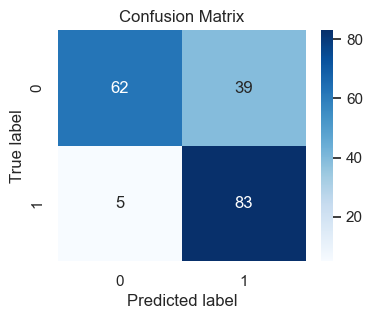

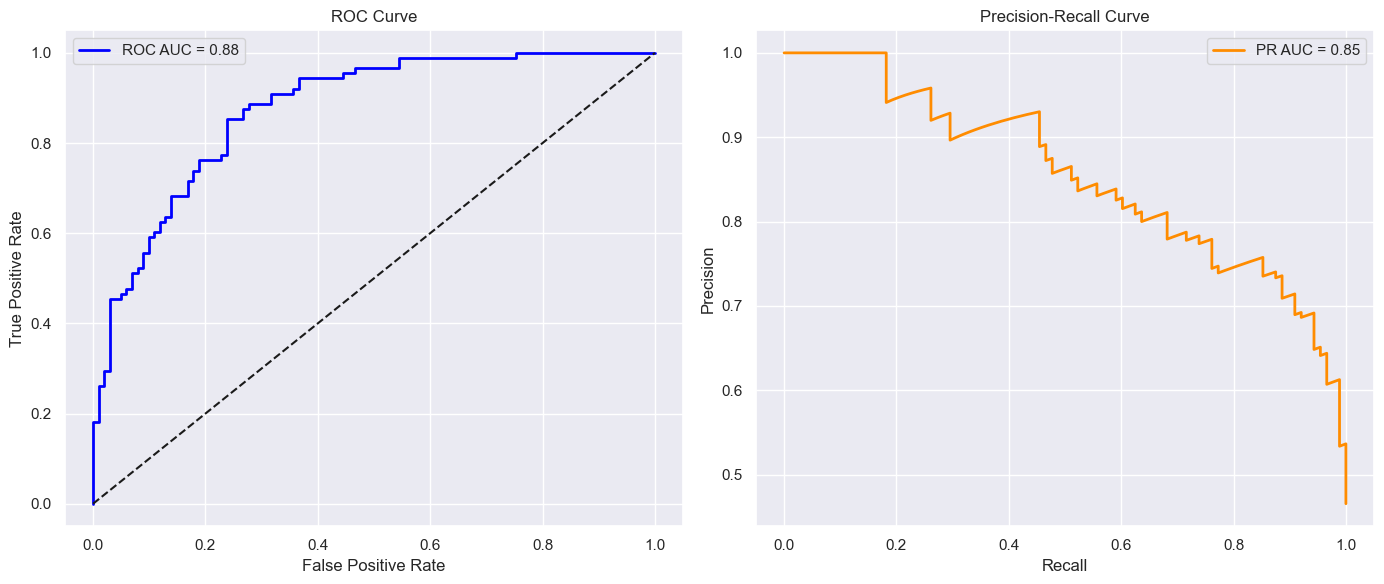

In [41]:
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        C=10,
        class_weight={0:1,1:3,2:6},
        random_state=42))
])

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

calculate_evaluation_metrics(lr, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_3_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    lr_bin = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            solver='lbfgs',
            C=10,
            class_weight={0:1,1:3},
            random_state=42))
    ])

    lr_bin.fit(X_train_bin, y_train_bin)

    y_pred_bin = lr_bin.predict(X_test_bin)
    y_pred_proba_bin = lr_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(lr_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
Player_class_num
1    351
0    351
2    351
Name: count, dtype: int64

=== Classification Report ===
               precision    recall  f1-score   support

           0       0.69      0.75      0.72        88
           1       0.59      0.48      0.53        75
           2       0.61      0.77      0.68        26

    accuracy                           0.65       189
   macro avg       0.63      0.67      0.64       189
weighted avg       0.64      0.65      0.64       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8221568225971402
PR AUC: 0.7096923950706423


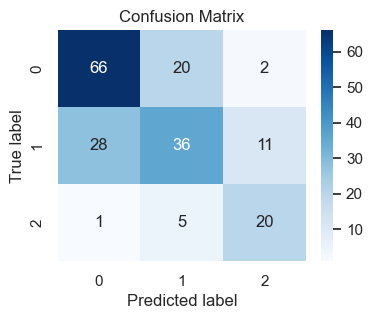

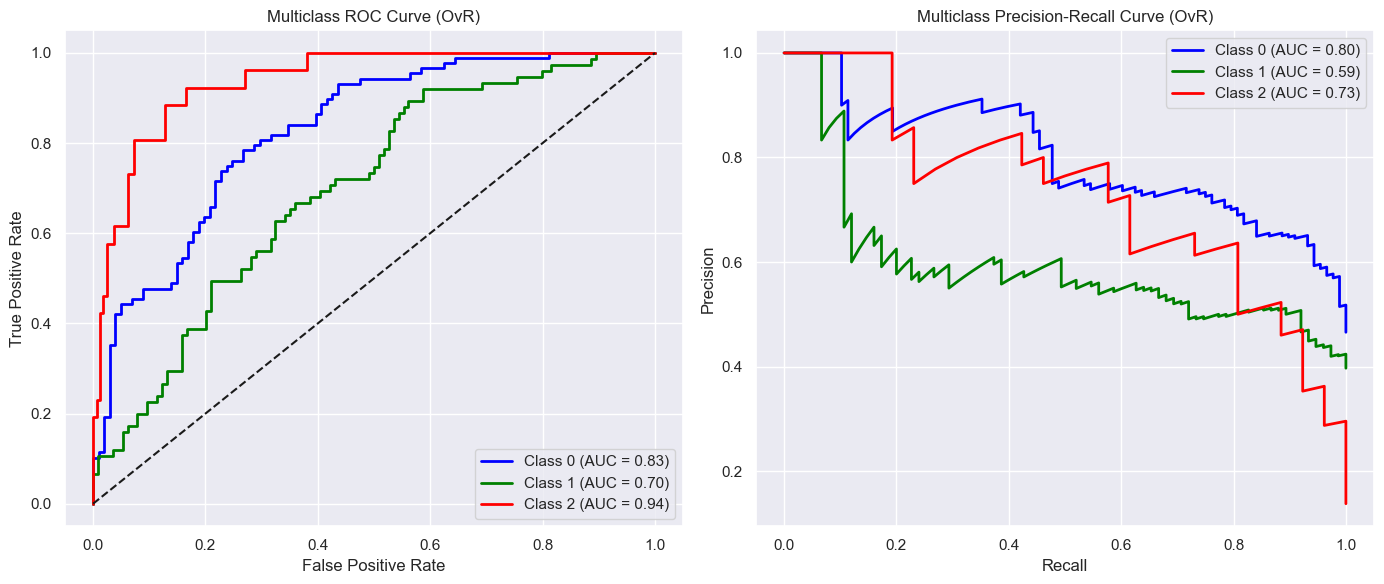

Number of elements in each class:
all-star_class
0    651
1    102
Name: count, dtype: int64

Number of elements in each class after sampling:
all-star_class
0    651
1    651
Name: count, dtype: int64

Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.95      0.83      0.89       163
           1       0.41      0.73      0.53        26

    accuracy                           0.82       189
   macro avg       0.68      0.78      0.71       189
weighted avg       0.88      0.82      0.84       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.9096271826333175
PR AUC: 0.6314515137974636


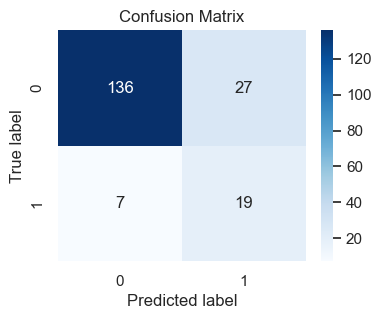

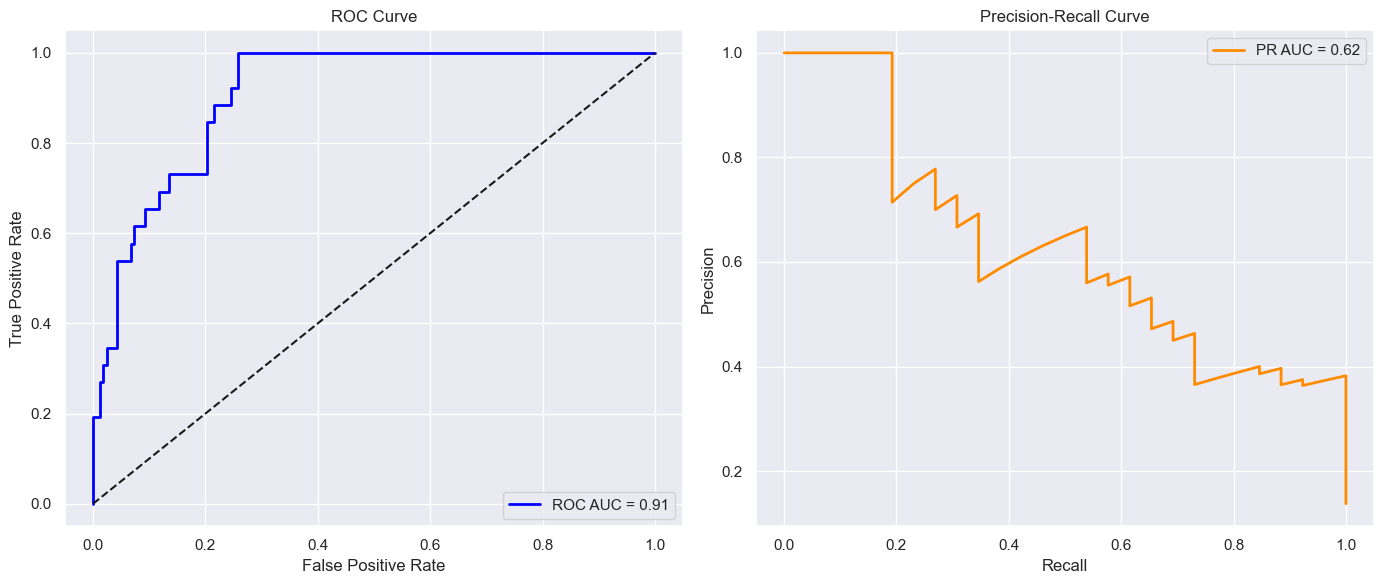

Number of elements in each class:
starter_class
0    453
1    300
Name: count, dtype: int64

Number of elements in each class after sampling:
starter_class
1    453
0    453
Name: count, dtype: int64

Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.77      0.66      0.71       114
           1       0.58      0.71      0.63        75

    accuracy                           0.68       189
   macro avg       0.67      0.68      0.67       189
weighted avg       0.69      0.68      0.68       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7093567251461989
PR AUC: 0.5429290705198682


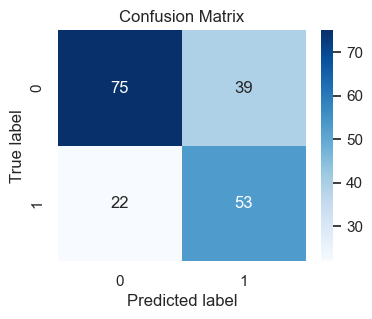

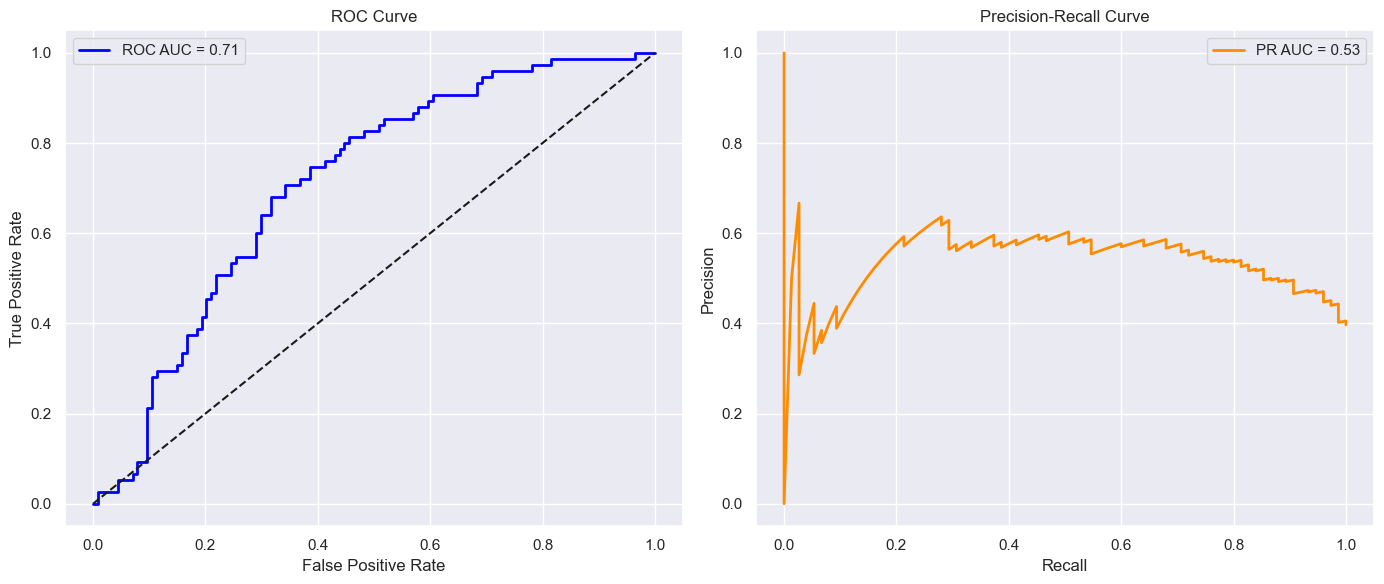

Number of elements in each class:
bench_class
0    402
1    351
Name: count, dtype: int64

Number of elements in each class after sampling:
bench_class
1    402
0    402
Name: count, dtype: int64

Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.83      0.77      0.80       101
           1       0.76      0.82      0.79        88

    accuracy                           0.79       189
   macro avg       0.79      0.80      0.79       189
weighted avg       0.80      0.79      0.79       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.876912691269127
PR AUC: 0.856716973466874


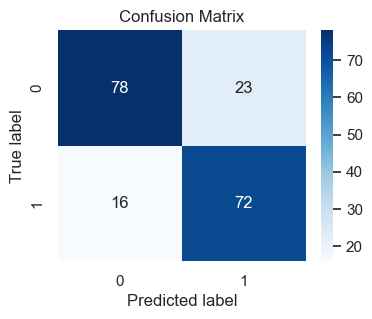

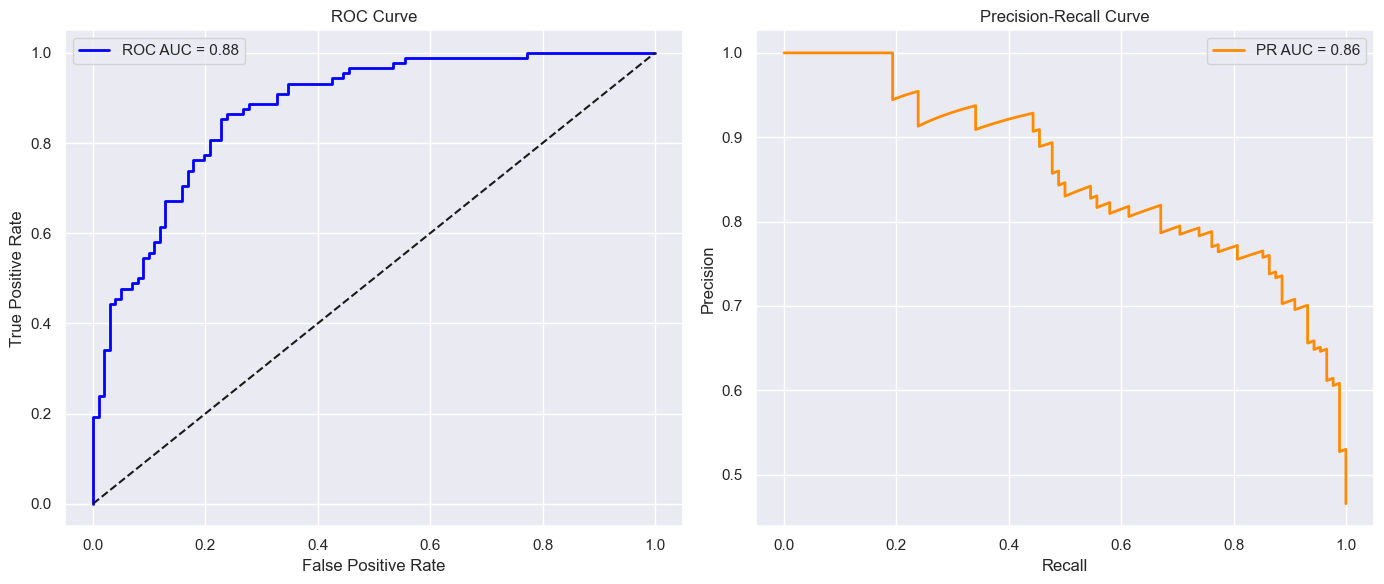

In [42]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print('Number of elements in each class:')
print(y_train.value_counts())
print('\nNumber of elements in each class after sampling:')
print(pd.Series(y_res).value_counts())

lr_smote = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        C=10,
        random_state=42))
])

lr_smote.fit(X_res, y_res)

y_pred = lr_smote.predict(X_test)
y_pred_proba = lr_smote.predict_proba(X_test)

calculate_evaluation_metrics(lr_smote, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_3_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    smote = SMOTE(random_state=42)
    X_res_bin, y_res_bin = smote.fit_resample(X_train_bin, y_train_bin)

    print('Number of elements in each class:')
    print(y_train_bin.value_counts())
    print('\nNumber of elements in each class after sampling:')
    print(pd.Series(y_res_bin).value_counts())
    
    lr_smote_bin = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            solver='lbfgs',
            C=10,
            random_state=42))
    ])

    lr_smote_bin.fit(X_res_bin, y_res_bin)

    y_pred_bin = lr_smote_bin.predict(X_test_bin)
    y_pred_proba_bin = lr_smote_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(lr_smote_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)

<h3>Classification results, input: statistics from the <b>rookie</b> season</h3>

In [60]:
df_1 = pd.read_csv('data/final_dataset_1_seasons.csv', low_memory=False)

class_mapping = {'bench': 0, 'starter': 1, 'all-star': 2}
df_1['Player_class_num'] = df_1['Player_class'].map(class_mapping)

final_dataset_1_seasons = df_1[get_selected_features(1)]

X = final_dataset_1_seasons.drop(columns=['Player_class_num'])
y = final_dataset_1_seasons['Player_class_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.68      0.75      0.71        88
           1       0.53      0.41      0.46        75
           2       0.45      0.58      0.51        26

    accuracy                           0.59       189
   macro avg       0.55      0.58      0.56       189
weighted avg       0.59      0.59      0.59       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7732780358668075
PR AUC: 0.6313688574638731


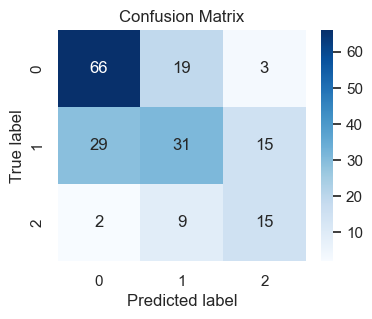

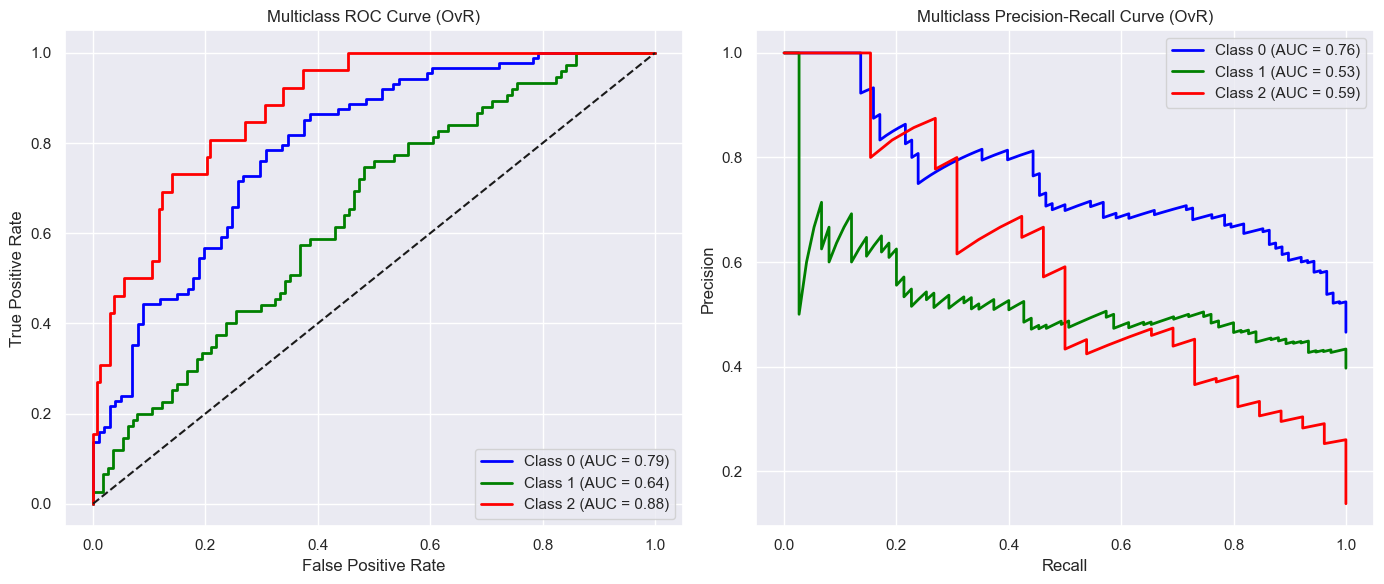


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.95      0.80      0.87       163
           1       0.37      0.73      0.49        26

    accuracy                           0.79       189
   macro avg       0.66      0.77      0.68       189
weighted avg       0.87      0.79      0.82       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8544124587069373
PR AUC: 0.5908372252962161


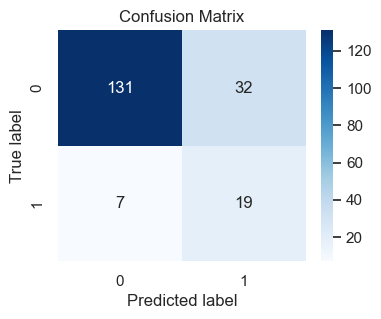

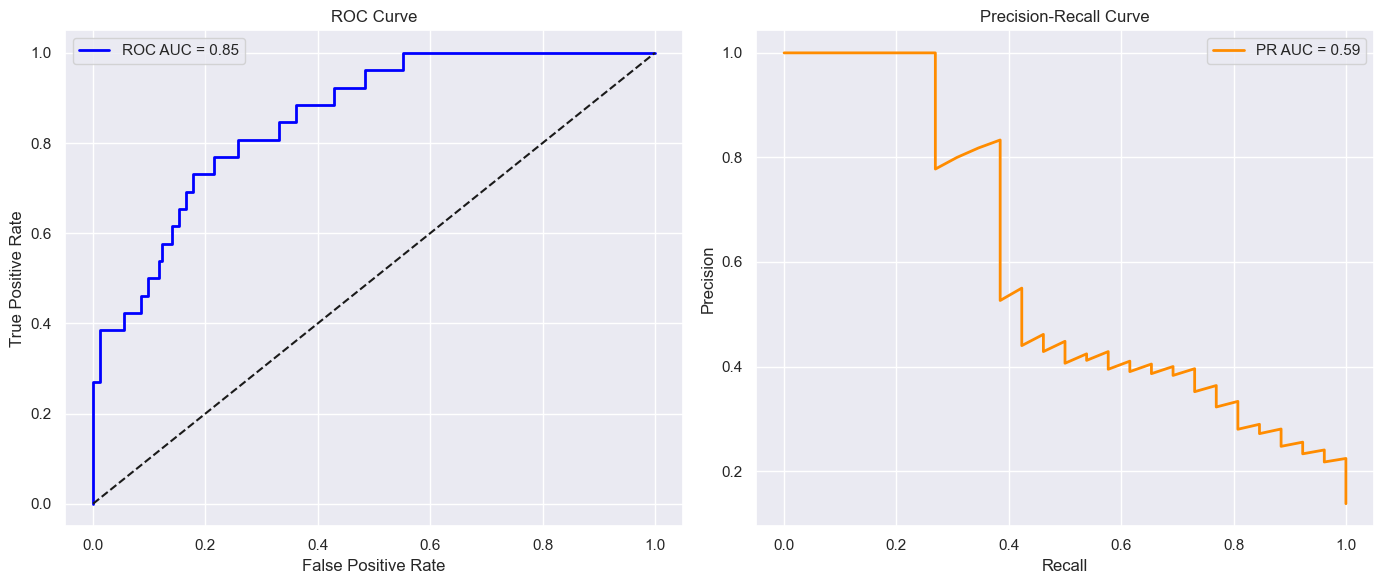


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.74      0.64      0.69       114
           1       0.55      0.67      0.60        75

    accuracy                           0.65       189
   macro avg       0.65      0.65      0.65       189
weighted avg       0.67      0.65      0.65       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.6676023391812865
PR AUC: 0.48973205107472106


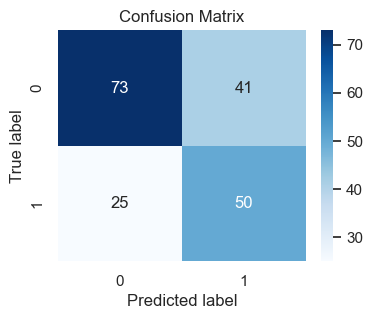

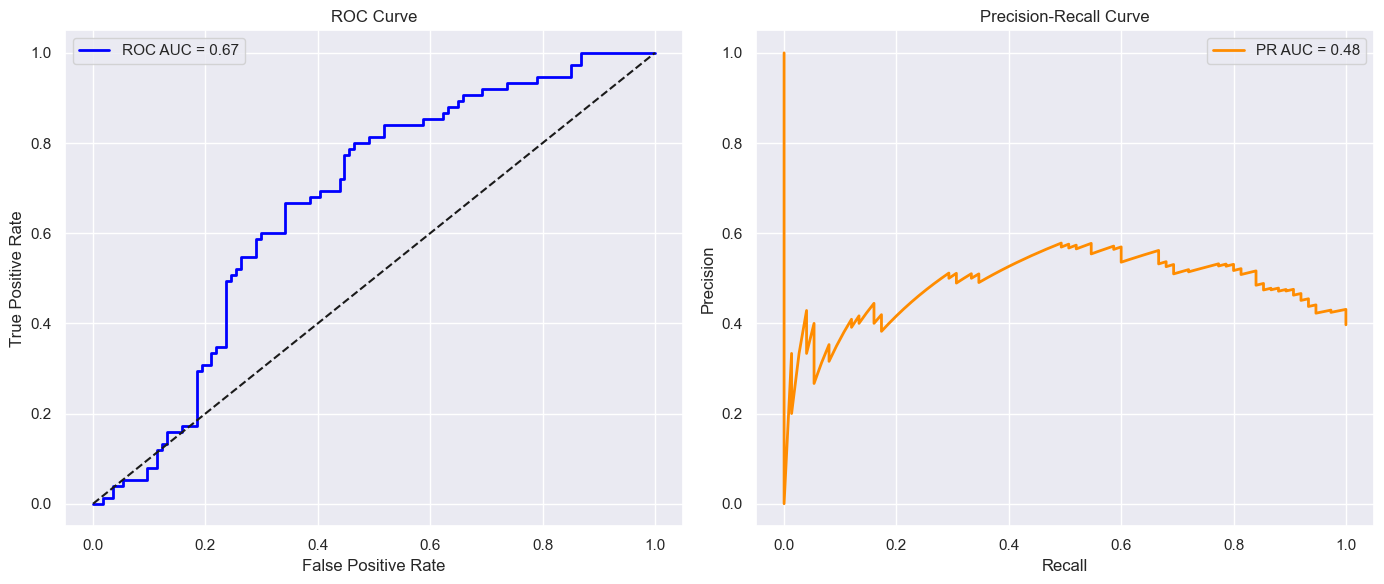


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.80      0.68      0.74       101
           1       0.69      0.81      0.74        88

    accuracy                           0.74       189
   macro avg       0.75      0.74      0.74       189
weighted avg       0.75      0.74      0.74       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8306705670567057
PR AUC: 0.800877312406


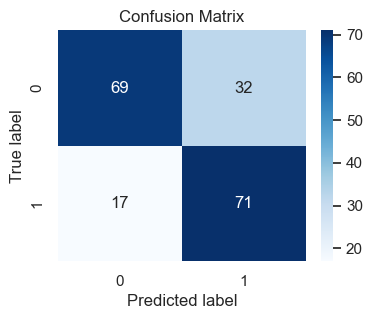

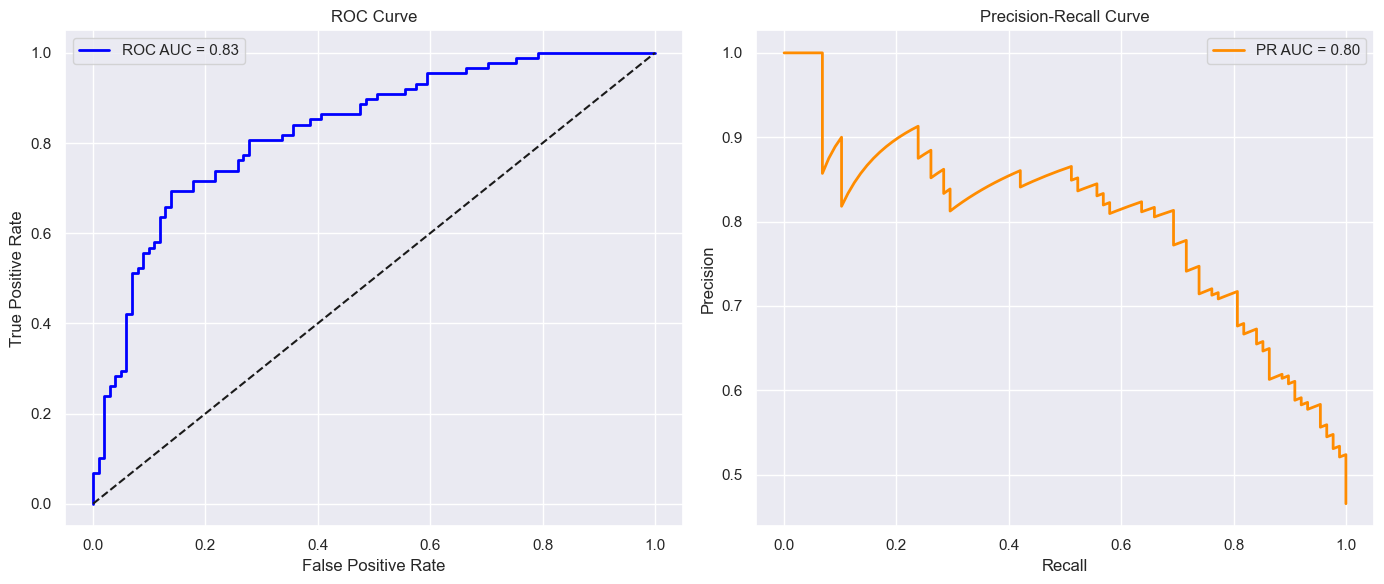

In [44]:
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        C=10,
        class_weight="balanced",
        random_state=42))
])

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

calculate_evaluation_metrics(lr, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_1_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    lr_bin = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            solver='lbfgs',
            C=10,
            class_weight="balanced",
            random_state=42))
    ])

    lr_bin.fit(X_train_bin, y_train_bin)

    y_pred_bin = lr_bin.predict(X_test_bin)
    y_pred_proba_bin = lr_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(lr_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.78      0.33      0.46        88
           1       0.45      0.79      0.57        75
           2       0.57      0.46      0.51        26

    accuracy                           0.53       189
   macro avg       0.60      0.53      0.52       189
weighted avg       0.62      0.53      0.51       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7641450928539201
PR AUC: 0.6252507066826833


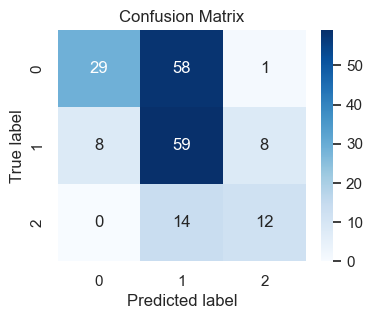

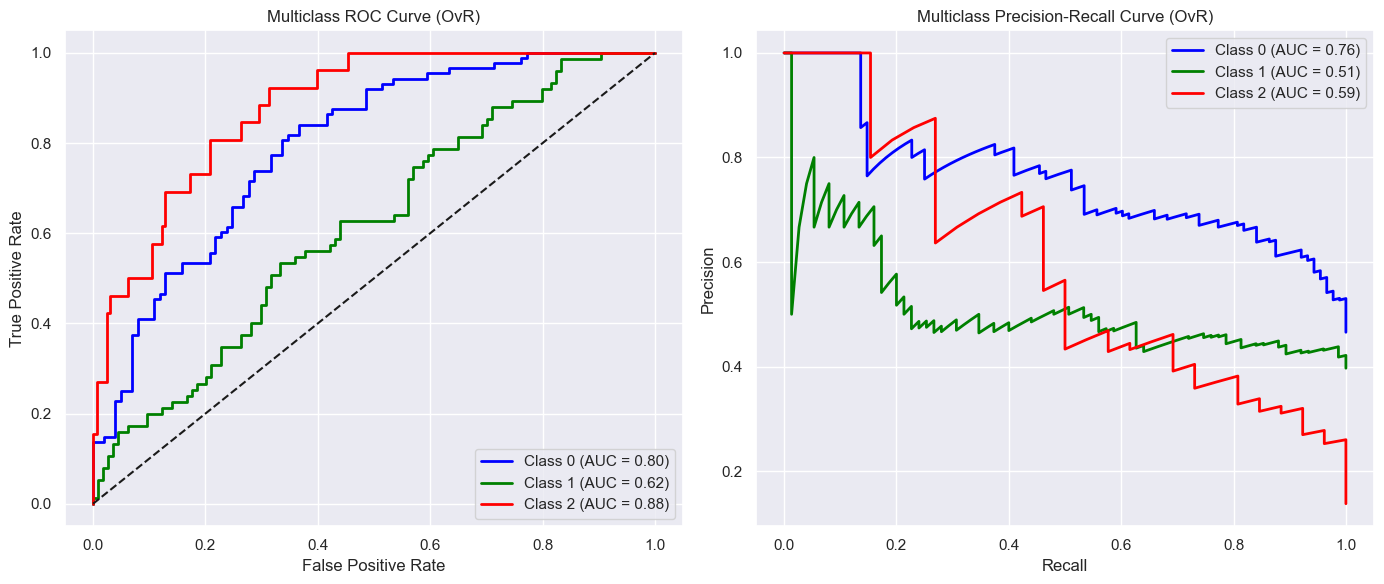


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.93      0.88      0.91       163
           1       0.44      0.58      0.50        26

    accuracy                           0.84       189
   macro avg       0.69      0.73      0.70       189
weighted avg       0.86      0.84      0.85       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8539405379896178
PR AUC: 0.5737238798399068


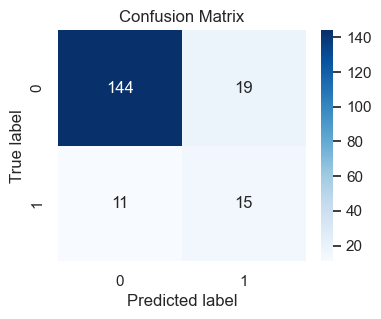

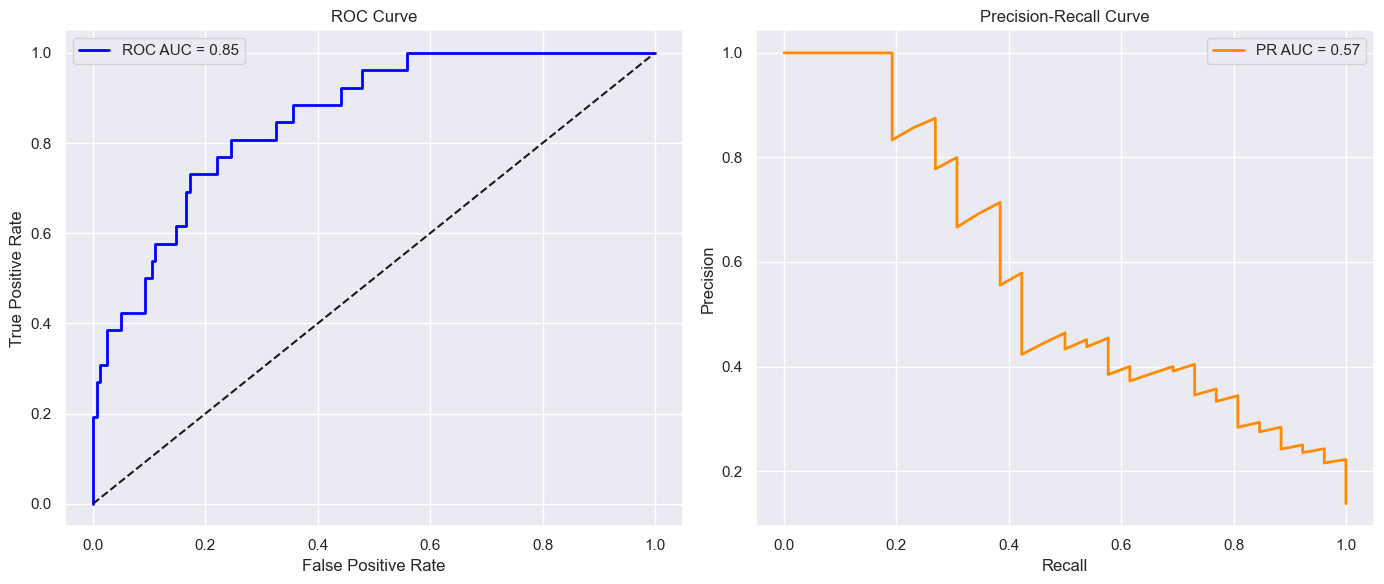


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.85      0.25      0.39       114
           1       0.45      0.93      0.61        75

    accuracy                           0.52       189
   macro avg       0.65      0.59      0.50       189
weighted avg       0.69      0.52      0.48       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.6680701754385964
PR AUC: 0.4874352070289755


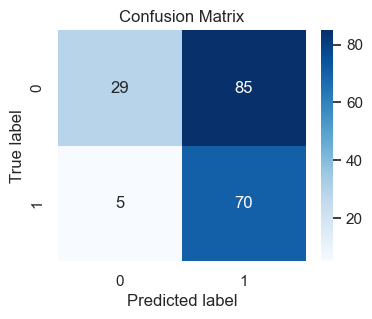

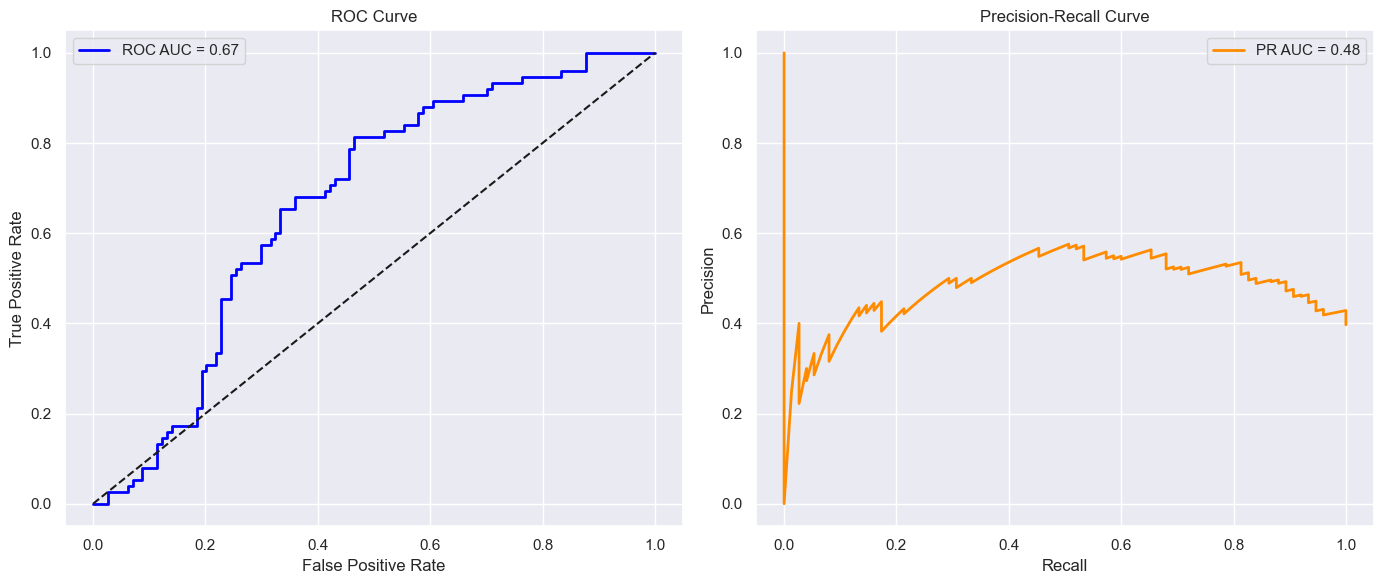


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.85      0.51      0.64       101
           1       0.62      0.90      0.73        88

    accuracy                           0.69       189
   macro avg       0.73      0.71      0.69       189
weighted avg       0.74      0.69      0.68       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8308955895589559
PR AUC: 0.8000806358044624


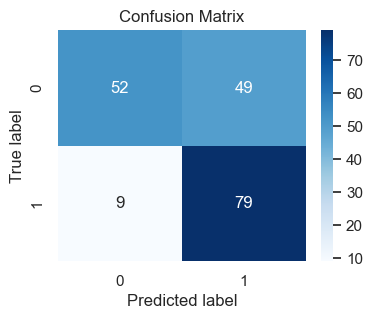

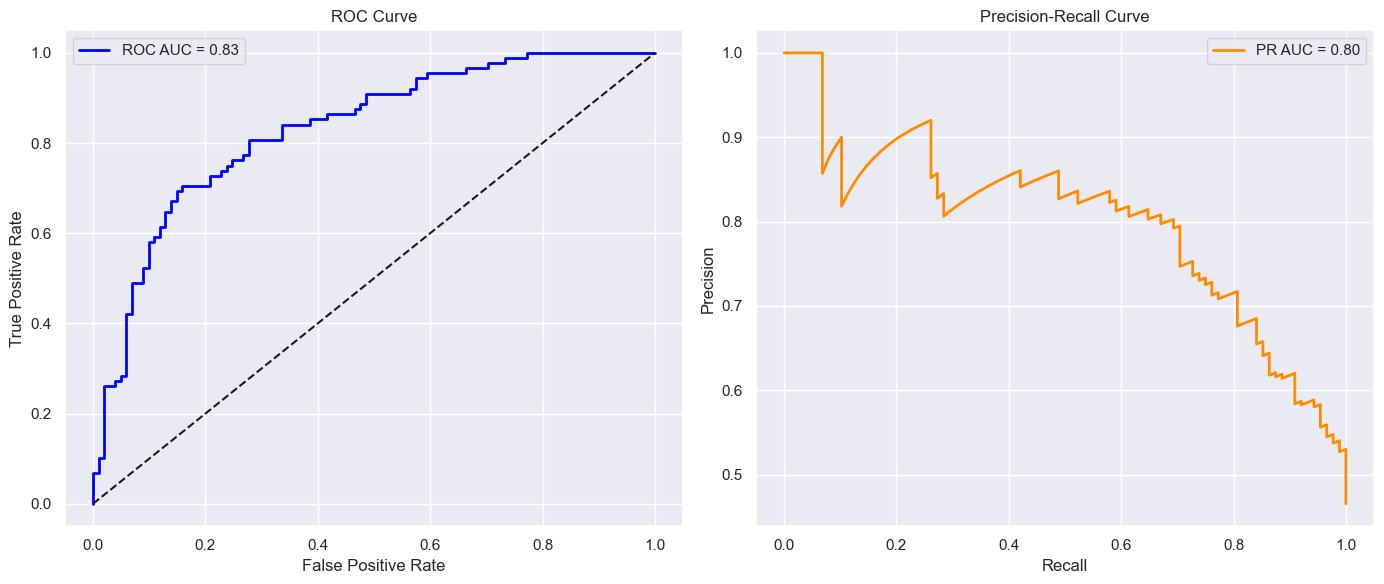

In [45]:
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        C=10,
        class_weight={0:1,1:3,2:6},
        random_state=42))
])

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

calculate_evaluation_metrics(lr, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_1_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    lr_bin = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            solver='lbfgs',
            C=10,
            class_weight={0:1,1:3},
            random_state=42))
    ])

    lr_bin.fit(X_train_bin, y_train_bin)

    y_pred_bin = lr_bin.predict(X_test_bin)
    y_pred_proba_bin = lr_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(lr_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
Player_class_num
1    351
0    351
2    351
Name: count, dtype: int64

=== Classification Report ===
               precision    recall  f1-score   support

           0       0.70      0.76      0.73        88
           1       0.53      0.43      0.47        75
           2       0.42      0.54      0.47        26

    accuracy                           0.60       189
   macro avg       0.55      0.58      0.56       189
weighted avg       0.59      0.60      0.59       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7692428960405954
PR AUC: 0.6355576344567312


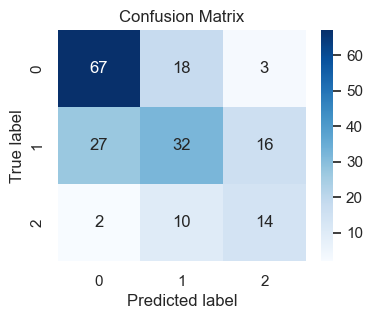

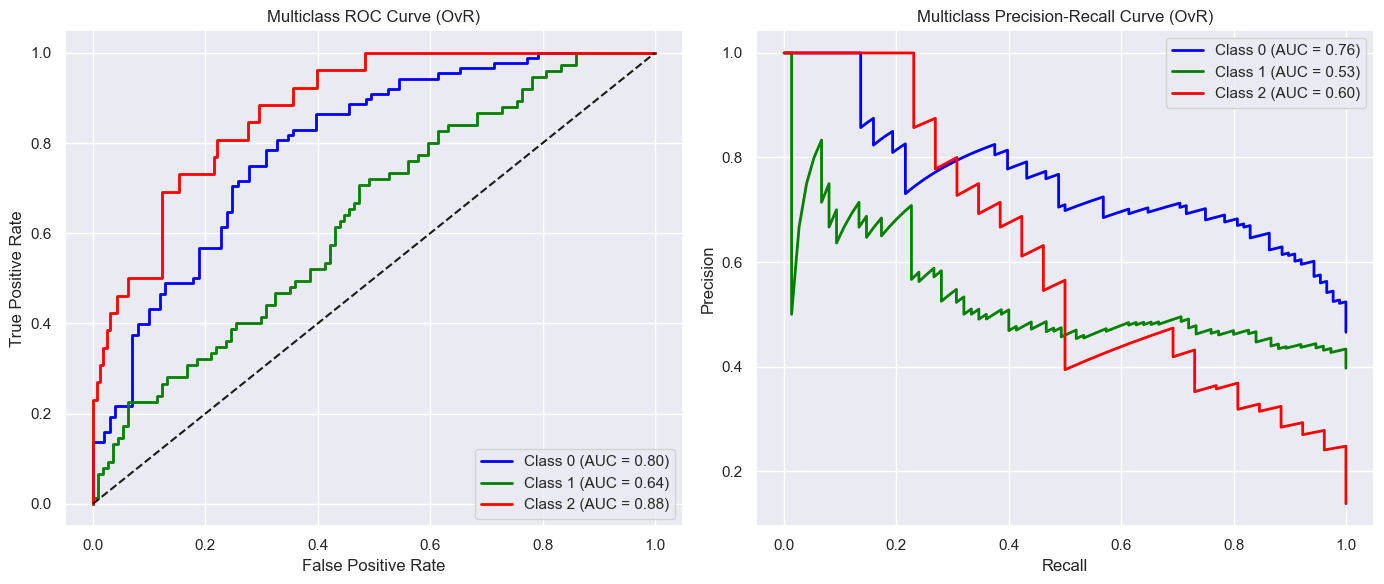

Number of elements in each class:
all-star_class
0    651
1    102
Name: count, dtype: int64

Number of elements in each class after sampling:
all-star_class
0    651
1    651
Name: count, dtype: int64

Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.95      0.80      0.87       163
           1       0.37      0.73      0.49        26

    accuracy                           0.79       189
   macro avg       0.66      0.76      0.68       189
weighted avg       0.87      0.79      0.81       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8496932515337423
PR AUC: 0.5633043617045729


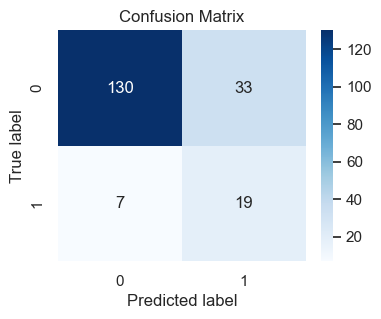

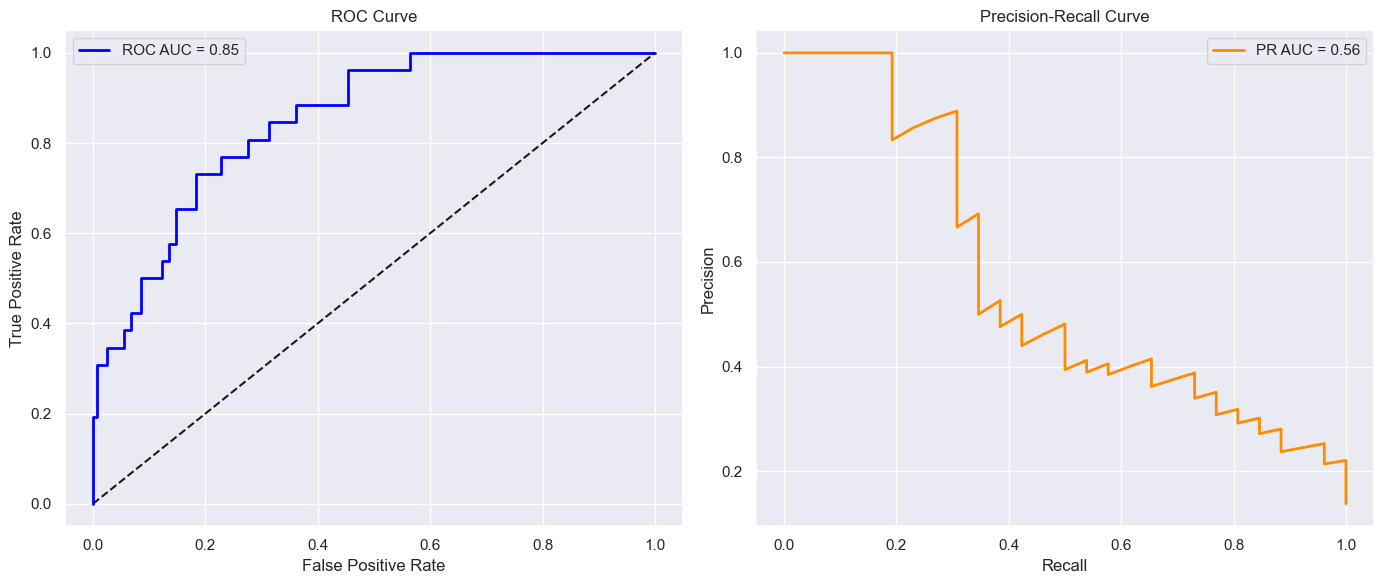

Number of elements in each class:
starter_class
0    453
1    300
Name: count, dtype: int64

Number of elements in each class after sampling:
starter_class
1    453
0    453
Name: count, dtype: int64

Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.73      0.63      0.68       114
           1       0.54      0.65      0.59        75

    accuracy                           0.64       189
   macro avg       0.64      0.64      0.63       189
weighted avg       0.66      0.64      0.64       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.6665497076023392
PR AUC: 0.48581277309144943


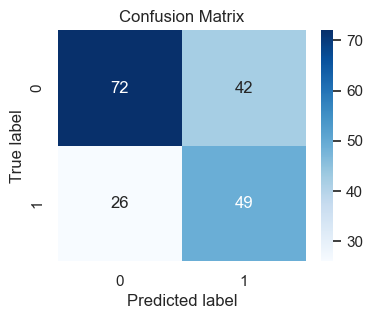

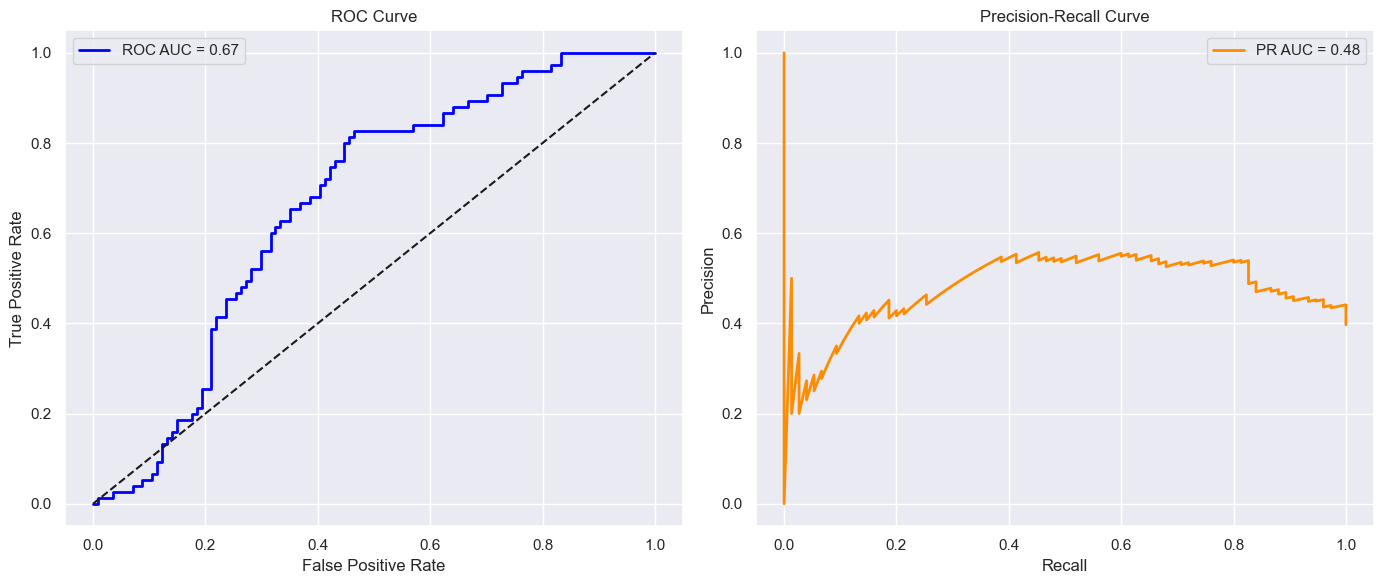

Number of elements in each class:
bench_class
0    402
1    351
Name: count, dtype: int64

Number of elements in each class after sampling:
bench_class
1    402
0    402
Name: count, dtype: int64

Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.80      0.68      0.74       101
           1       0.69      0.81      0.74        88

    accuracy                           0.74       189
   macro avg       0.75      0.74      0.74       189
weighted avg       0.75      0.74      0.74       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8301080108010801
PR AUC: 0.7989780594535637


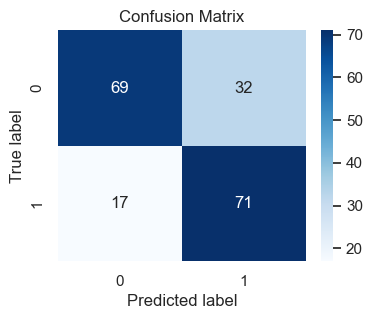

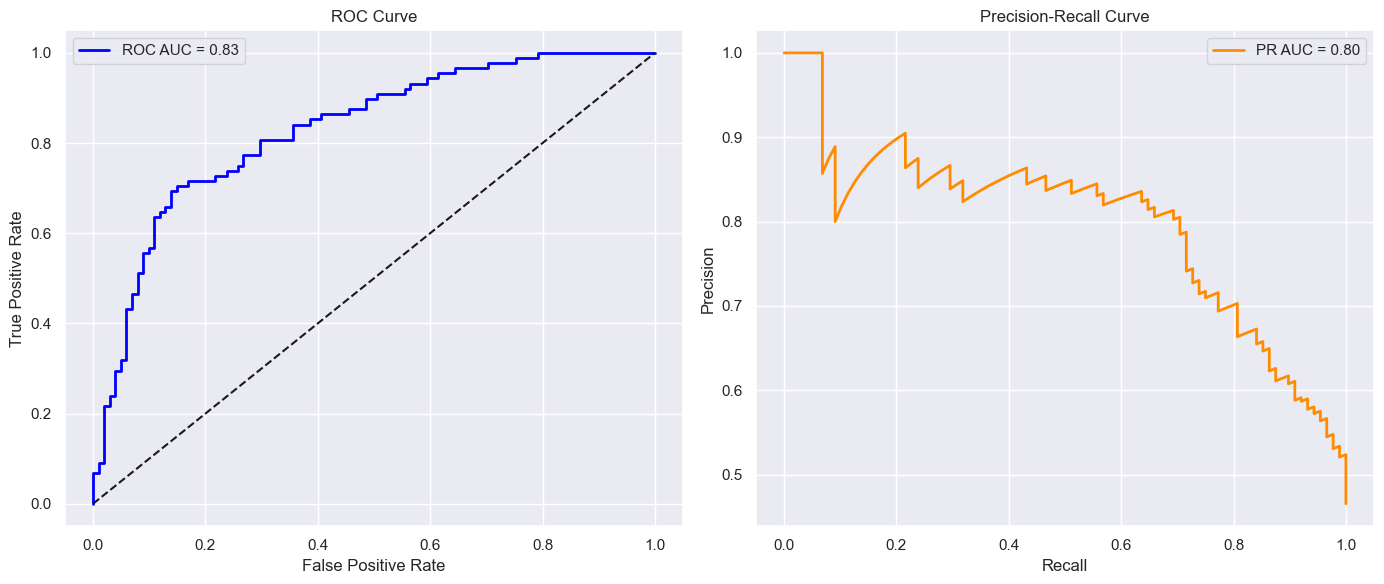

In [61]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print('Number of elements in each class:')
print(y_train.value_counts())
print('\nNumber of elements in each class after sampling:')
print(pd.Series(y_res).value_counts())

lr_smote = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        C=10,
        random_state=42))
])

lr_smote.fit(X_res, y_res)

y_pred = lr_smote.predict(X_test)
y_pred_proba = lr_smote.predict_proba(X_test)

calculate_evaluation_metrics(lr_smote, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_1_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    smote = SMOTE(random_state=42)
    X_res_bin, y_res_bin = smote.fit_resample(X_train_bin, y_train_bin)

    print('Number of elements in each class:')
    print(y_train_bin.value_counts())
    print('\nNumber of elements in each class after sampling:')
    print(pd.Series(y_res_bin).value_counts())
    
    lr_smote_bin = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            solver='lbfgs',
            C=10,
            random_state=42))
    ])

    lr_smote_bin.fit(X_res_bin, y_res_bin)

    y_pred_bin = lr_smote_bin.predict(X_test_bin)
    y_pred_proba_bin = lr_smote_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(lr_smote_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)

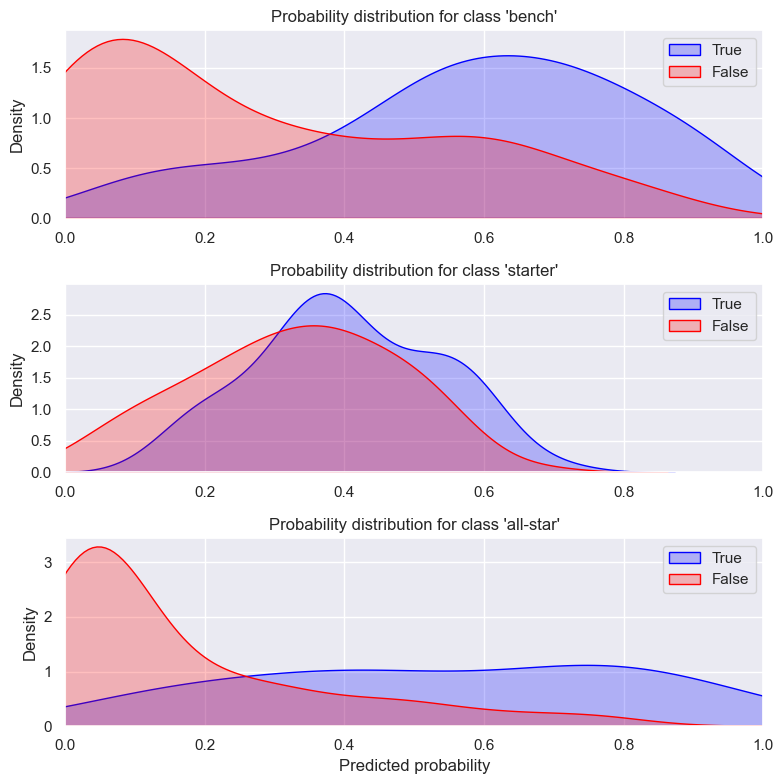

PermutationExplainer explainer: 190it [00:21,  4.64it/s]                         


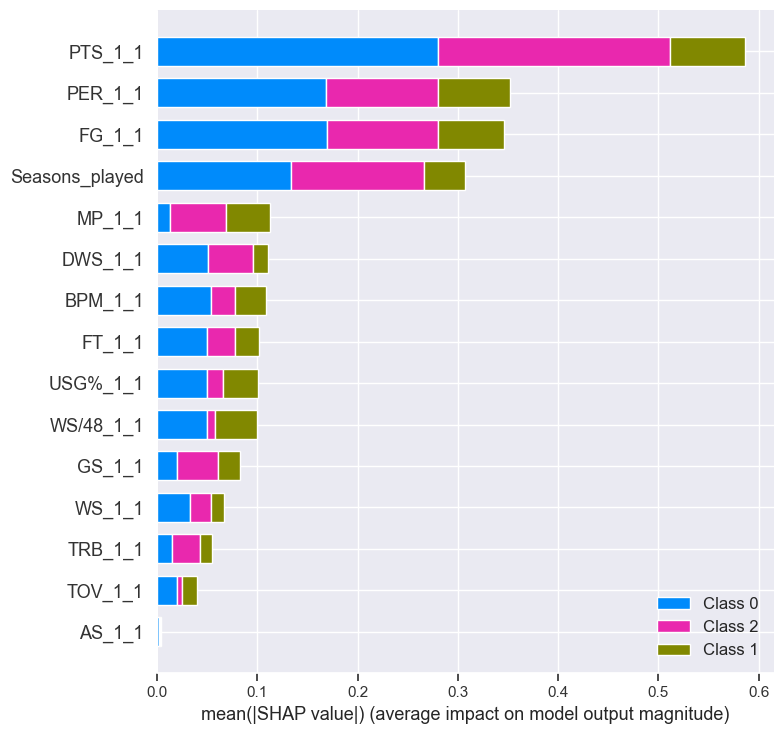

In [62]:
plot_class_probability_distributions(y_test, y_pred_proba)
display_shap_plot(lr_smote, X_res, X_test)

In [63]:
display_lime_plot(lr_smote, X_res, X_test, 0)